In [2]:
# ===== LIBRARY IMPORTS =====
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# External package setup
sys.path.append(os.path.expanduser('~/Desktop/diss/particles-cdssm'))

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm

# Data source
import yfinance as yf

# Time series analysis
from statsmodels.tsa.stattools import acf

# JAX ecosystem
import jax
import jax.numpy as jnp
import jax.lax as lax

# NumPyro for Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

# Particles package
import particles
from particles import state_space_models as ssm
from particles import mcmc, distributions
from particles.collectors import Moments
from particles_cdssm.collectors import ObservationPredictiveParticles, ObservationPredictiveMoments, NLPD
from particles.state_space_models import StochVol, Bootstrap

print("All libraries imported successfully")
print(f"NumPyro version: {numpyro.__version__}")
print(f"JAX version: {jax.__version__}")

All libraries imported successfully
NumPyro version: 0.18.0
JAX version: 0.4.30


## 1. Data Collection and Preprocessing

### Fetch S&P 500 and NASDAQ Returns
Download financial data and compute log returns for the joint volatility analysis.

In [4]:
def fetch_spy_eem_data(start_date="2015-01-01", end_date="2022-01-01"):
    """
    Fetch SPY (S&P 500) and EEM (Emerging Markets) data and compute log returns.
    
    Returns:
        tuple: (returns_df, returns_array) - DataFrame and numpy array of returns
    """
    # Download data
    tickers = ["SPY", "EEM"]  # S&P 500 ETF and Emerging Markets ETF
    data = yf.download(tickers, start=start_date, end=end_date, progress=False,auto_adjust=True)
    
    # Extract closing prices and compute log returns (in %)
    spy_close = data['Close']['SPY']
    eem_close = data['Close']['EEM']
    
    spy_returns = np.log(spy_close / spy_close.shift(1)) * 100
    eem_returns = np.log(eem_close / eem_close.shift(1)) * 100
    
    # Create DataFrame and remove NaNs
    returns_df = pd.DataFrame({
        'SPY': spy_returns,
        'EEM': eem_returns
    }).dropna()
    
    returns_array = returns_df.values
    
    # Summary statistics
    print(f"📊 Data Summary ({len(returns_df)} trading days):")
    print(f"   Period: {returns_df.index[0].date()} to {returns_df.index[-1].date()}")
    print(f"   SPY:  μ={returns_df['SPY'].mean():.3f}%, σ={returns_df['SPY'].std():.2f}%")
    print(f"   EEM:  μ={returns_df['EEM'].mean():.3f}%, σ={returns_df['EEM'].std():.2f}%")
    print(f"   Correlation: ρ={returns_df['SPY'].corr(returns_df['EEM']):.3f}")
    
    # Data quality check
    if returns_df.isnull().any().any():
        n_nans = returns_df.isnull().sum().sum()
        print(f"⚠️  Warning: Removed {n_nans} NaN values")
        returns_df = returns_df.dropna()
        returns_array = returns_df.values
    
    print(f"✅ Returns array shape: {returns_array.shape}")
    return returns_df, returns_array

# Fetch the data
returns_df, returns_array = fetch_spy_eem_data()

📊 Data Summary (1762 trading days):
   Period: 2015-01-05 to 2021-12-31
   SPY:  μ=0.055%, σ=1.12%
   EEM:  μ=0.021%, σ=1.36%
   Correlation: ρ=0.789
✅ Returns array shape: (1762, 2)


### Data Visualization and Exploratory Analysis

Comprehensive visualization of the bivariate return series to understand volatility clustering, correlation structure, and distributional properties.

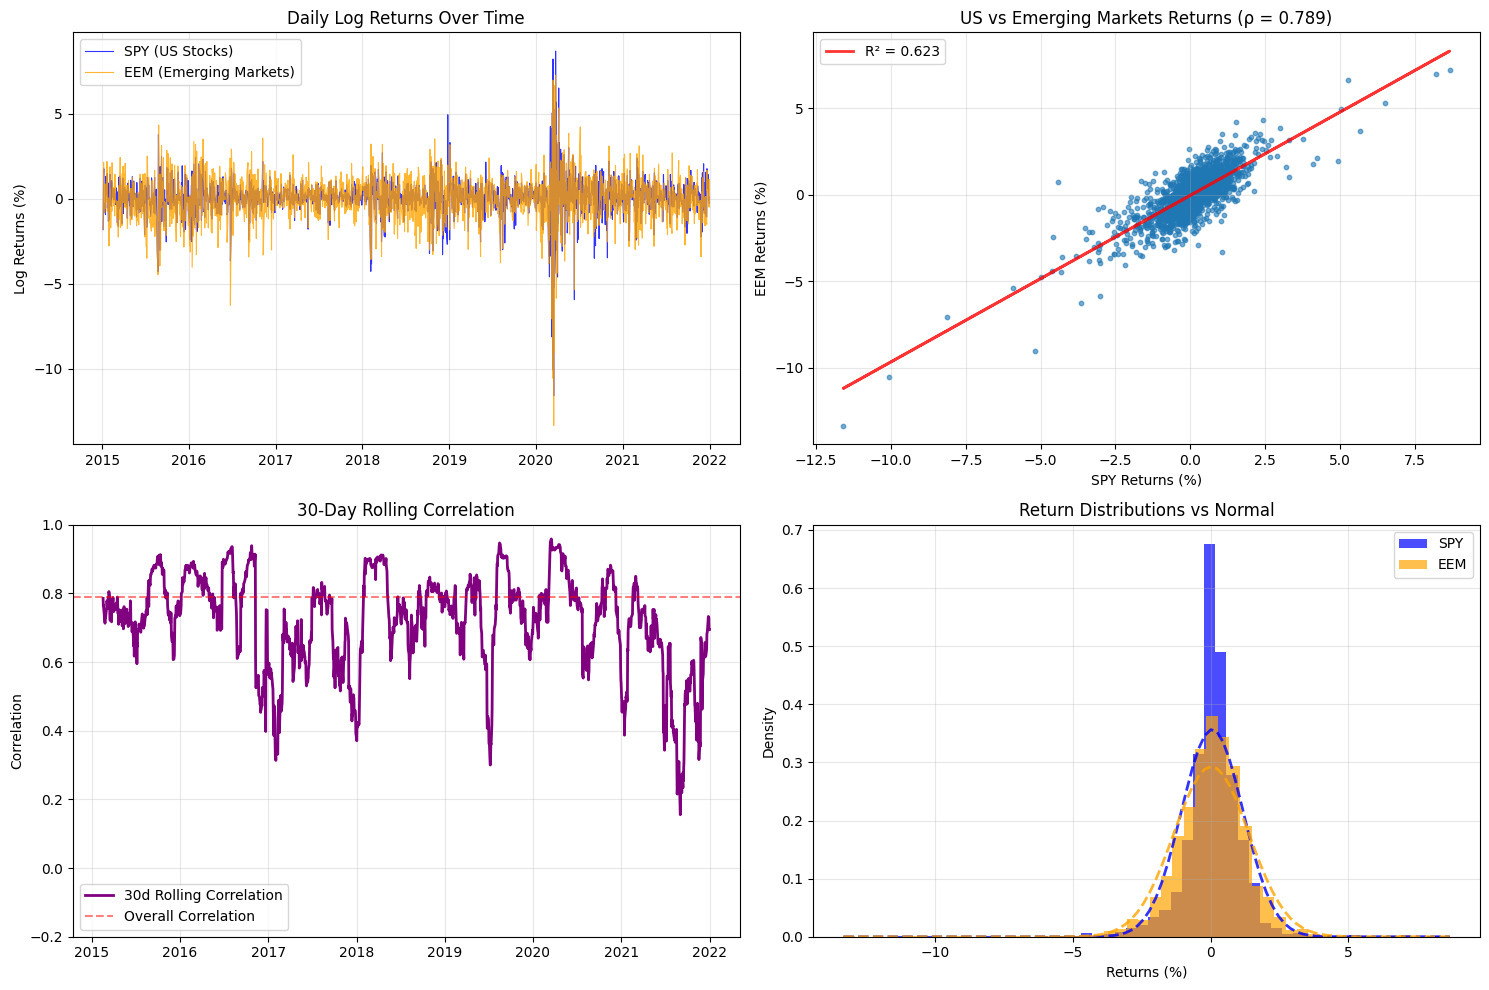

📊 DETAILED DATA SUMMARY
Period: 2015-01-05 to 2021-12-31
Observations: 1762 trading days

DESCRIPTIVE STATISTICS:
  SPY: μ= 0.055%, σ= 1.12%, Skew=-1.037, Kurt=18.489
  EEM: μ= 0.021%, σ= 1.36%, Skew=-1.028, Kurt=10.135

CORRELATION & VOLATILITY:
  Overall Correlation: 0.7894
  Correlation Range: [0.155, 0.959]
  Annualized volatility - SPY: 17.75%, EEM: 21.64%

EXTREME EVENTS (1% tails):
  SPY: worst < -3.25% (18 days), best > 2.55% (18 days)
  EEM: worst < -3.51% (18 days), best > 3.19% (18 days)


In [5]:
def plot_spy_eem_overview(returns_df):
    """Create comprehensive overview plots of SPY and EEM data."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Time series of returns
    ax1 = axes[0, 0]
    ax1.plot(returns_df.index, returns_df['SPY'], label='SPY (US Stocks)', alpha=0.8, linewidth=0.8, color='blue')
    ax1.plot(returns_df.index, returns_df['EEM'], label='EEM (Emerging Markets)', alpha=0.8, linewidth=0.8, color='orange')
    ax1.set_title('Daily Log Returns Over Time')
    ax1.set_ylabel('Log Returns (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Scatter plot with regression line
    ax2 = axes[0, 1]
    ax2.scatter(returns_df['SPY'], returns_df['EEM'], alpha=0.6, s=10)
    correlation = returns_df["SPY"].corr(returns_df["EEM"])
    
    # Add regression line
    slope, intercept, r_value, _, _ = stats.linregress(returns_df['SPY'], returns_df['EEM'])
    line = slope * returns_df['SPY'] + intercept
    ax2.plot(returns_df['SPY'], line, 'r-', alpha=0.8, linewidth=2, label=f'R² = {r_value**2:.3f}')
    ax2.set_xlabel('SPY Returns (%)')
    ax2.set_ylabel('EEM Returns (%)')
    ax2.set_title(f'US vs Emerging Markets Returns (ρ = {correlation:.3f})')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Rolling correlation (30-day window)
    ax3 = axes[1, 0]
    window = 30
    rolling_corr = returns_df['SPY'].rolling(window=window).corr(returns_df['EEM'])
    
    ax3.plot(returns_df.index, rolling_corr, label=f'{window}d Rolling Correlation', linewidth=2, color='purple')
    ax3.axhline(y=correlation, color='red', linestyle='--', alpha=0.5, label='Overall Correlation')
    ax3.set_title(f'{window}-Day Rolling Correlation')
    ax3.set_ylabel('Correlation')
    ax3.set_ylim(-0.2, 1)  # Adjusted for typical range of this pair
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Distribution comparison
    ax4 = axes[1, 1]
    ax4.hist(returns_df['SPY'], bins=50, alpha=0.7, label='SPY', density=True, color='blue')
    ax4.hist(returns_df['EEM'], bins=50, alpha=0.7, label='EEM', density=True, color='orange')
    
    # Normal distribution overlays
    x_range = np.linspace(min(returns_df['SPY'].min(), returns_df['EEM'].min()),
                         max(returns_df['SPY'].max(), returns_df['EEM'].max()), 100)
    
    for col, color, style in [('SPY', 'blue', '--'), ('EEM', 'orange', '--')]:
        normal_dist = stats.norm.pdf(x_range, returns_df[col].mean(), returns_df[col].std())
        ax4.plot(x_range, normal_dist, color=color, linestyle=style, alpha=0.8, linewidth=2)
    
    ax4.set_xlabel('Returns (%)')
    ax4.set_ylabel('Density')
    ax4.set_title('Return Distributions vs Normal')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("📊 DETAILED DATA SUMMARY")
    print("=" * 50)
    print(f"Period: {returns_df.index[0].date()} to {returns_df.index[-1].date()}")
    print(f"Observations: {len(returns_df)} trading days")
    
    print("\nDESCRIPTIVE STATISTICS:")
    for col in ['SPY', 'EEM']:
        data = returns_df[col]
        print(f"  {col:>3}: μ={data.mean():6.3f}%, σ={data.std():5.2f}%, "
              f"Skew={data.skew():6.3f}, Kurt={data.kurtosis():6.3f}")
    
    print(f"\nCORRELATION & VOLATILITY:")
    print(f"  Overall Correlation: {correlation:.4f}")
    print(f"  Correlation Range: [{rolling_corr.min():.3f}, {rolling_corr.max():.3f}]")
    spy_ann = returns_df['SPY'].std() * np.sqrt(252)
    eem_ann = returns_df['EEM'].std() * np.sqrt(252)
    print(f"  Annualized volatility - SPY: {spy_ann:.2f}%, EEM: {eem_ann:.2f}%")
    
    print(f"\nEXTREME EVENTS (1% tails):")
    for col in ['SPY', 'EEM']:
        data = returns_df[col]
        q01, q99 = data.quantile([0.01, 0.99])
        extreme_down = (data <= q01).sum()
        extreme_up = (data >= q99).sum()
        print(f"  {col:>3}: worst < {q01:.2f}% ({extreme_down} days), "
              f"best > {q99:.2f}% ({extreme_up} days)")

# Create the visualization
plot_spy_eem_overview(returns_df)

### Train/Test Split

Split the data into training and testing sets for out-of-sample model evaluation.

In [7]:
def split_data_2d(returns_df, returns_array, train_ratio=0.7):
    """Split 2D data into training and testing sets."""
    n_total = len(returns_df)
    n_train = int(n_total * train_ratio)
    
    # Split data
    train_df = returns_df.iloc[:n_train].copy()
    test_df = returns_df.iloc[n_train:].copy()
    train_array = returns_array[:n_train]
    test_array = returns_array[n_train:]
    
    print(f"📊 Data Split Summary:")
    print(f"   Training: {len(train_df)} days ({train_df.index[0].date()} to {train_df.index[-1].date()})")
    print(f"   Testing:  {len(test_df)} days ({test_df.index[0].date()} to {test_df.index[-1].date()})")
    print(f"   Training correlation: {train_df['SPY'].corr(train_df['EEM']):.3f}")
    print(f"   Testing correlation:  {test_df['SPY'].corr(test_df['EEM']):.3f}")
    print(f"   Array shapes: Train{train_array.shape}, Test{test_array.shape}")
    
    return train_df, test_df, train_array, test_array

# Split the data
train_df, test_df, train_array, test_array = split_data_2d(returns_df, returns_array, train_ratio=0.7)

# Store individual series for convenience
spy_train, eem_train = train_df['SPY'].values, train_df['EEM'].values
spy_test, eem_test = test_df['SPY'].values, test_df['EEM'].values

print("✅ Data split completed successfully")

📊 Data Split Summary:
   Training: 1233 days (2015-01-05 to 2019-11-25)
   Testing:  529 days (2019-11-26 to 2021-12-31)
   Training correlation: 0.764
   Testing correlation:  0.824
   Array shapes: Train(1233, 2), Test(529, 2)
✅ Data split completed successfully


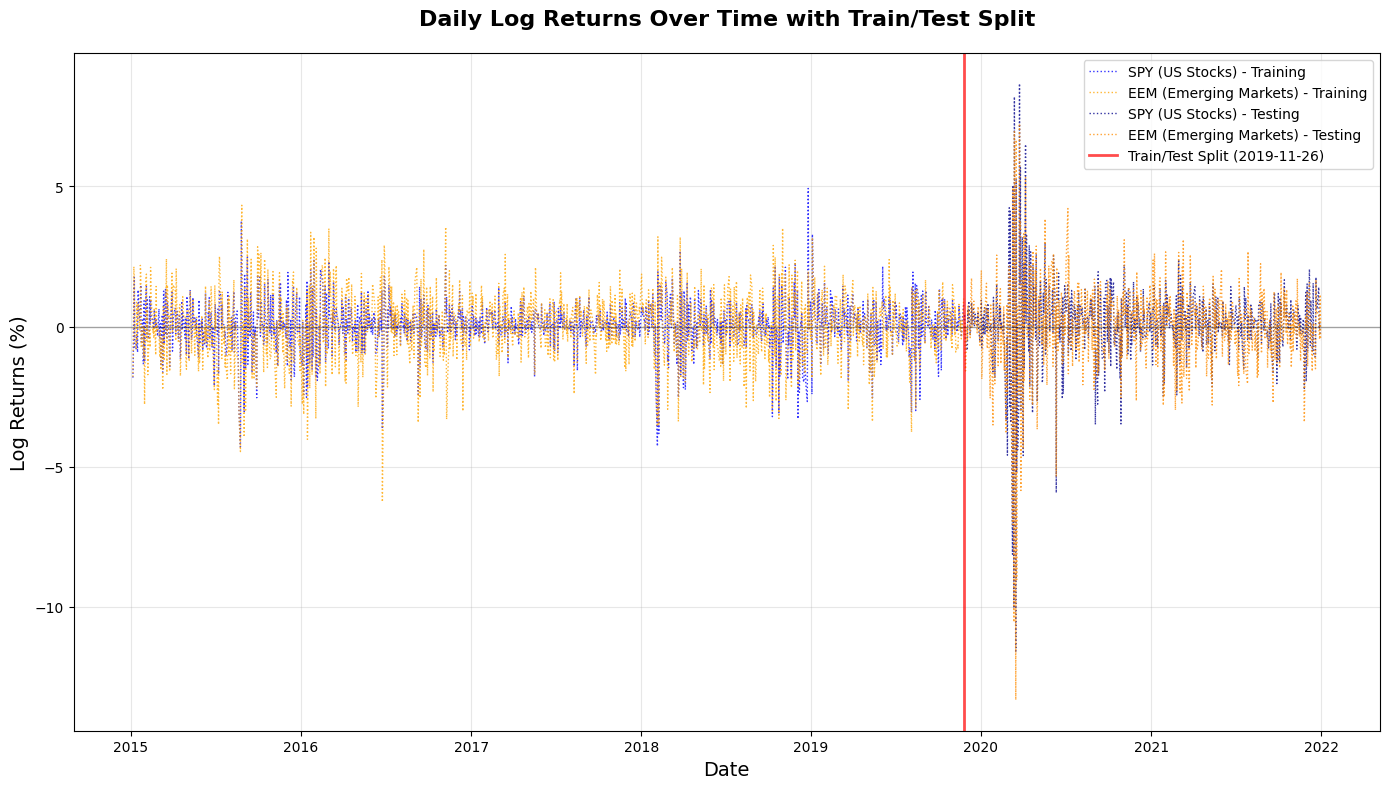


📊 TIME SERIES WITH TRAIN/TEST SPLIT
Total Period: 2015-01-05 to 2021-12-31
Total Trading Days: 1762
Training Split: 1233 days (70.0%)
Testing Split: 529 days (30.0%)
Split Date: 2019-11-26

Correlation Analysis:
Overall Correlation: 0.789
Training Correlation: 0.764
Testing Correlation: 0.824

Volatility Comparison:
SPY Training Vol: 0.853%  |  Testing Vol: 1.572%
EEM Training Vol: 1.193%  |  Testing Vol: 1.696%


In [8]:
def plot_returns_with_split(returns_df, train_df, test_df):
    """
    Create time series plot of SPY and EEM returns with train/test split visualization
    """
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Calculate split date
    split_date = test_df.index[0]
    
    # Plot training data (dotted lines)
    ax.plot(train_df.index, train_df['SPY'], 
            label='SPY (US Stocks) - Training', alpha=0.8, linewidth=1, color='blue', linestyle=':')
    ax.plot(train_df.index, train_df['EEM'], 
            label='EEM (Emerging Markets) - Training', alpha=0.8, linewidth=1, color='orange', linestyle=':')
    
    # Plot testing data (dotted lines, different colors)
    ax.plot(test_df.index, test_df['SPY'], 
            label='SPY (US Stocks) - Testing', alpha=0.8, linewidth=1, color='darkblue', linestyle=':')
    ax.plot(test_df.index, test_df['EEM'], 
            label='EEM (Emerging Markets) - Testing', alpha=0.8, linewidth=1, color='darkorange', linestyle=':')
    
    # Add vertical line for split
    ax.axvline(x=split_date, color='red', linestyle='-', linewidth=2, alpha=0.7, 
               label=f'Train/Test Split ({split_date.date()})')
    
    # Add zero line
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    
    # Formatting
    ax.set_title('Daily Log Returns Over Time with Train/Test Split', fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel('Log Returns (%)', fontsize=14)
    ax.set_xlabel('Date', fontsize=14)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Format x-axis
    ax.tick_params(axis='x', rotation=0, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print split summary
    print("\n" + "="*60)
    print("📊 TIME SERIES WITH TRAIN/TEST SPLIT")
    print("="*60)
    print(f"Total Period: {returns_df.index[0].strftime('%Y-%m-%d')} to {returns_df.index[-1].strftime('%Y-%m-%d')}")
    print(f"Total Trading Days: {len(returns_df)}")
    print(f"Training Split: {len(train_df)} days ({len(train_df)/len(returns_df):.1%})")
    print(f"Testing Split: {len(test_df)} days ({len(test_df)/len(returns_df):.1%})")
    print(f"Split Date: {split_date.strftime('%Y-%m-%d')}")
    
    print("\nCorrelation Analysis:")
    overall_corr = returns_df['SPY'].corr(returns_df['EEM'])
    train_corr = train_df['SPY'].corr(train_df['EEM'])
    test_corr = test_df['SPY'].corr(test_df['EEM'])
    print(f"Overall Correlation: {overall_corr:.3f}")
    print(f"Training Correlation: {train_corr:.3f}")
    print(f"Testing Correlation: {test_corr:.3f}")
    
    print("\nVolatility Comparison:")
    print(f"SPY Training Vol: {train_df['SPY'].std():.3f}%  |  Testing Vol: {test_df['SPY'].std():.3f}%")
    print(f"EEM Training Vol: {train_df['EEM'].std():.3f}%  |  Testing Vol: {test_df['EEM'].std():.3f}%")

# Create the plot
plot_returns_with_split(returns_df, train_df, test_df)

## DC_MSV (Model 5) definition

In [10]:
class DC_MSV(ssm.StateSpaceModel):
    """
    Dynamic Conditional Multivariate Stochastic Volatility Model
    
    State: [h1_t, h2_t, q_t] where h1,h2 are log-volatilities, q is transformed correlation
    """
    def __init__(self, mu1, mu2, phi11, phi22, sigma_eta1, sigma_eta2, psi0, psi, sigma_rho):
        # Store parameters
        self.mu1, self.mu2 = mu1, mu2
        self.phi11, self.phi22 = phi11, phi22
        self.sigma_eta1, self.sigma_eta2 = sigma_eta1, sigma_eta2
        self.psi0, self.psi = psi0, psi
        self.sigma_rho = sigma_rho
        
        # State transition matrices
        self.a = np.array([mu1 * (1 - phi11), mu2 * (1 - phi22), psi0 * (1 - psi)])
        self.B = np.diag([phi11, phi22, psi])
        self.Sigma = np.diag([sigma_eta1**2, sigma_eta2**2, sigma_rho**2])

    def PX0(self):
        """Initial state distribution"""
        return distributions.MvNormal(loc=np.array([self.mu1, self.mu2, self.psi0]), cov=np.eye(3))

    def PX(self, t, xp):
        """State transition: X_t | X_{t-1}"""
        mean = self.a + np.dot(self.B, xp.T).T
        return distributions.MvNormal(loc=mean, cov=self.Sigma)

    def PY(self, t, xp, x):
        """Observation distribution: Y_t | X_t"""
        h1, h2, q = x[:, 0], x[:, 1], x[:, 2]
        
        # Transform to correlation and volatilities
        rho = np.clip((np.exp(q) - 1) / (np.exp(q) + 1), -0.999, 0.999)
        vol1, vol2 = np.exp(h1 / 2), np.exp(h2 / 2)
        
        class VectorizedBivariateNormal:
            """Custom vectorized bivariate normal for particle filtering"""
            def __init__(self, vol1, vol2, rho):
                self.vol1, self.vol2, self.rho = vol1, vol2, rho
                self.N = len(vol1)
            
            def logpdf(self, y):
                if len(y.shape) == 1:
                    y = y.reshape(1, -1)
                
                logpdfs = np.zeros(self.N)
                for i in range(self.N):
                    # Covariance matrix for particle i
                    var1, var2 = self.vol1[i]**2 + 1e-6, self.vol2[i]**2 + 1e-6
                    cov12 = self.rho[i] * self.vol1[i] * self.vol2[i]
                    cov_i = np.array([[var1, cov12], [cov12, var2]])
                    
                    # Log-likelihood calculation
                    det_cov = np.linalg.det(cov_i)
                    if det_cov <= 0:
                        logpdfs[i] = -np.inf
                    else:
                        diff = y[0]  # y is (1, 2)
                        inv_cov = np.linalg.inv(cov_i)
                        exponent = -0.5 * diff @ inv_cov @ diff.T
                        normalization = -0.5 * (2 * np.log(2 * np.pi) + np.log(det_cov))
                        logpdfs[i] = exponent + normalization
                
                return logpdfs
            
            def rvs(self, size=None):
                if size is None:
                    size = self.N
                samples = np.zeros((size, 2))
                for i in range(size):
                    particle_idx = i % self.N
                    var1 = self.vol1[particle_idx]**2 + 1e-6
                    var2 = self.vol2[particle_idx]**2 + 1e-6
                    cov12 = self.rho[particle_idx] * self.vol1[particle_idx] * self.vol2[particle_idx]
                    cov_i = np.array([[var1, cov12], [cov12, var2]])
                    samples[i] = np.random.multivariate_normal(np.zeros(2), cov_i)
                return samples
        
        return VectorizedBivariateNormal(vol1, vol2, rho)

## Baseline Model: Bivariate Normal

Simple constant covariance model for comparison (equivalent to 2D Black-Scholes assumption).

In [12]:
class BivariateNormal(ssm.StateSpaceModel):
    """Simple constant bivariate normal model (2D Black-Scholes equivalent)"""
    
    def __init__(self, data):
        self.data = np.array(data)
        self.mean = np.mean(self.data, axis=0)  # Should be close to [0, 0]
        self.cov = np.cov(self.data.T) + 1e-6 * np.eye(2)  # Add regularization
    
    def PX0(self):
        """Dummy initial state"""
        return distributions.MvNormal(loc=np.zeros(2), cov=0.001 * np.eye(2))
    
    def PX(self, t, xp):
        """Dummy state transition"""
        return distributions.MvNormal(loc=xp, cov=0.0001 * np.eye(2))
    
    def PY(self, t, xp, x):
        """Observation model: Y_t ~ N(μ, Σ) with constant parameters"""
        N = len(x)
        
        class ConstantBivariateNormal:
            def __init__(self, mean, cov, N):
                self.mean, self.cov, self.N = mean, cov, N
            
            def logpdf(self, y):
                if len(y.shape) == 1:
                    y = y.reshape(1, -1)
                
                diff = y[0] - self.mean
                det_cov = np.linalg.det(self.cov)
                
                if det_cov <= 0:
                    return np.full(self.N, -np.inf)
                
                inv_cov = np.linalg.inv(self.cov)
                exponent = -0.5 * diff @ inv_cov @ diff.T
                normalization = -0.5 * (2 * np.log(2 * np.pi) + np.log(det_cov))
                return np.full(self.N, exponent + normalization)
            
            def rvs(self, size=None):
                if size is None:
                    size = self.N
                return np.random.multivariate_normal(self.mean, self.cov, size)
        
        return ConstantBivariateNormal(self.mean, self.cov, N)

## GARCH(1,1) 2d equivalent

In [13]:
import numpy as np

class CCC_GARCH_11:
    """
    Constant Conditional Correlation GARCH(1,1) model (Bollerslev, 1990).
    
    H_t = D_t R D_t
    D_t = diag(sqrt(h1_t), sqrt(h2_t))
    """
    def __init__(self, omega1, alpha1, beta1,
                       omega2, alpha2, beta2,
                       rho):
        self.omega1, self.alpha1, self.beta1 = omega1, alpha1, beta1
        self.omega2, self.alpha2, self.beta2 = omega2, alpha2, beta2
        self.rho = rho
        
        # Constant correlation matrix
        self.R = np.array([[1.0, rho],
                           [rho, 1.0]])
    
    def initialize_variances(self, y0):
        """Initialize conditional variances with sample variances or constant."""
        h1_0 = np.var(y0[:, 0])
        h2_0 = np.var(y0[:, 1])
        return h1_0, h2_0
    
    def fit_placeholder(self, y):
        """
        Placeholder for estimation (e.g., MLE or quasi-MLE).
        Here just returns initial variances.
        """
        return self.initialize_variances(y)
    
    def forecast_covariance(self, y, h1_prev, h2_prev):
        """One-step-ahead forecast of covariance matrix H_t."""
        # Update variances
        h1_t = self.omega1 + self.alpha1 * (y[-1, 0]**2) + self.beta1 * h1_prev
        h2_t = self.omega2 + self.alpha2 * (y[-1, 1]**2) + self.beta2 * h2_prev
        
        # Build conditional covariance matrix
        D_t = np.diag([np.sqrt(h1_t), np.sqrt(h2_t)])
        H_t = D_t @ self.R @ D_t
        return H_t, h1_t, h2_t


## 3. Bayesian Parameter Estimation

### HMC/NUTS Estimation with NumPyro

Efficient Bayesian estimation using Hamiltonian Monte Carlo with non-centered parameterization for improved sampling efficiency.

In [15]:
def numpyro_estimation_dc_msv(returns_array, n_iter=10000, n_warmup=2000, n_chains=2):
    """
    Optimized HMC estimation for DC-MSV model using non-centered parameterization.
    
    Args:
        returns_array: (T, 2) array of returns
        n_iter: Total iterations per chain
        n_warmup: Warmup iterations
        n_chains: Number of parallel chains
    
    Returns:
        dict: MCMC results and parameter estimates
    """
    jax.config.update("jax_platform_name", "cpu")
    T, _ = returns_array.shape
    y_data = jnp.array(returns_array)
    
    def dc_msv_model(y=None):
        # Prior distributions
        # Use data-informed priors
        y_mean = jnp.mean(jnp.log(jnp.var(y_data, axis=0) + 1e-6))  # Empirical log-variance
        mu1 = numpyro.sample('mu1', dist.Normal(y_mean, 1.0))  # Tighter, data-informed
        mu2 = numpyro.sample('mu2', dist.Normal(y_mean, 1.0))
        phi11 = numpyro.sample('phi11', dist.Beta(20., 1.5))
        phi22 = numpyro.sample('phi22', dist.Beta(20., 1.5))
        sigma1 = numpyro.sample('sigma1', dist.InverseGamma(2.5, 0.025))
        sigma2 = numpyro.sample('sigma2', dist.InverseGamma(2.5, 0.025))
        mu0 = numpyro.sample('mu0', dist.Normal(0.7, 3.))
        phi = numpyro.sample('phi', dist.Beta(20., 1.5))
        sigma_rho = numpyro.sample('sigma_rho', dist.InverseGamma(2.5, 0.025))

        # Stationary variances for initial states
        var_h1 = sigma1**2 / (1 - phi11**2 + 1e-6)
        var_h2 = sigma2**2 / (1 - phi22**2 + 1e-6)
        var_q = sigma_rho**2 / (1 - phi**2 + 1e-6)

        # Non-centered initial states
        h1_0_tilde = numpyro.sample('h1_0_tilde', dist.Normal(0., 1.))
        h2_0_tilde = numpyro.sample('h2_0_tilde', dist.Normal(0., 1.))
        q_0_tilde = numpyro.sample('q_0_tilde', dist.Normal(0., 1.))

        h1_init = mu1 + jnp.sqrt(var_h1) * h1_0_tilde
        h2_init = mu2 + jnp.sqrt(var_h2) * h2_0_tilde
        q_init = mu0 + jnp.sqrt(var_q) * q_0_tilde
        init_state = jnp.array([h1_init, h2_init, q_init])

        # Non-centered innovations for state transitions
        with numpyro.plate('time', T-1):
            h1_tilde = numpyro.sample('h1_tilde', dist.Normal(0., 1.))
            h2_tilde = numpyro.sample('h2_tilde', dist.Normal(0., 1.))
            q_tilde = numpyro.sample('q_tilde', dist.Normal(0., 1.))

        tildes = jnp.stack([h1_tilde, h2_tilde, q_tilde], axis=1)

        # State evolution using scan
        def state_step(state_prev, tilde):
            h1_prev, h2_prev, q_prev = state_prev
            h1 = mu1 + phi11 * (h1_prev - mu1) + sigma1 * tilde[0]
            h2 = mu2 + phi22 * (h2_prev - mu2) + sigma2 * tilde[1]
            q = mu0 + phi * (q_prev - mu0) + sigma_rho * tilde[2]
            new_state = jnp.array([h1, h2, q])
            return new_state, new_state

        _, states_rest = lax.scan(state_step, init_state, tildes)
        states = jnp.concatenate([init_state[None, :], states_rest], axis=0)
        numpyro.deterministic('states', states)

        # Observation model
        with numpyro.plate('obs', T):
            h1, h2, q = states[:, 0], states[:, 1], states[:, 2]
            rho_t = (jnp.exp(q) - 1) / (jnp.exp(q) + 1)
            Omega_t = jnp.stack([jnp.exp(h1 / 2), jnp.exp(h2 / 2)], axis=1)
            
            # Time-varying covariance matrices
            covs = jnp.zeros((T, 2, 2))
            covs = covs.at[:, 0, 0].set(Omega_t[:, 0]**2)
            covs = covs.at[:, 1, 1].set(Omega_t[:, 1]**2)
            covs = covs.at[:, 0, 1].set(rho_t * Omega_t[:, 0] * Omega_t[:, 1])
            covs = covs.at[:, 1, 0].set(rho_t * Omega_t[:, 0] * Omega_t[:, 1])
            covs = covs + 1e-5 * jnp.eye(2)  # Regularization
            
            numpyro.sample('y', dist.MultivariateNormal(loc=jnp.zeros(2), covariance_matrix=covs), obs=y)

    print(f"Running DC-MSV estimation ({n_chains} chains, {n_iter} iterations each)...")
    
    # Run NUTS sampler
    nuts_kernel = NUTS(dc_msv_model)
    mcmc = MCMC(nuts_kernel, num_warmup=n_warmup, num_samples=n_iter - n_warmup, 
                num_chains=n_chains, progress_bar=True)
    mcmc.run(jax.random.PRNGKey(0), y=y_data)
    
    # Extract and summarize results
    samples = mcmc.get_samples()
    params = ['mu1', 'mu2', 'phi11', 'phi22', 'sigma1', 'sigma2', 'mu0', 'phi', 'sigma_rho']
    param_estimates = {}
    
    for param in params:
        param_samples = samples[param]
        param_estimates[param] = {
            'mean': float(jnp.mean(param_samples)),
            'std': float(jnp.std(param_samples)),
            'quantiles': [float(q) for q in jnp.quantile(param_samples, jnp.array([0.025, 0.5, 0.975]))]
        }
    
    print("NumPyro estimation completed")
    print("\nParameter Estimates (Posterior Means):")
    print("-" * 50)
    for param, est in param_estimates.items():
        print(f"  {param:>10}: {est['mean']:7.4f} ± {est['std']:6.4f}")
    
    return {
        'mcmc': mcmc,
        'samples': samples,
        'estimates': param_estimates,
        'param_names': params
    }

In [16]:
# === MODEL FITTING PIPELINE ===

print("Starting model fitting pipeline...")

# 1. Convert returns to decimal scale (from percentage)
train_array_decimal = train_array / 100
test_array_decimal = test_array / 100

# 2. Create baseline model
baseline_model = BivariateNormal(train_array_decimal)
print("Baseline bivariate normal model created")

# 3. Run Bayesian parameter estimation
print("\nRunning HMC estimation for DC-MSV parameters...")
results = numpyro_estimation_dc_msv(train_array_decimal, n_iter=20000, n_warmup=5000)

Starting model fitting pipeline...
Baseline bivariate normal model created

Running HMC estimation for DC-MSV parameters...
Running DC-MSV estimation (2 chains, 20000 iterations each)...


sample: 100%|██████████| 20000/20000 [03:11<00:00, 104.43it/s, 63 steps of size 6.93e-02. acc. prob=0.88]


NumPyro estimation completed

Parameter Estimates (Posterior Means):
--------------------------------------------------
         mu1: -10.2521 ± 0.3017
         mu2: -9.1635 ± 0.1991
       phi11:  0.9711 ± 0.0101
       phi22:  0.9768 ± 0.0107
      sigma1:  0.2774 ± 0.0391
      sigma2:  0.1347 ± 0.0292
         mu0:  2.9708 ± 0.1766
         phi:  0.9308 ± 0.0531
   sigma_rho:  0.0528 ± 0.1051



Running MCMC diagnostics...

MCMC CONVERGENCE DIAGNOSTICS
Total iterations: 30000
Post-burnin samples: 30000

Effective Sample Sizes:
  Volatility parameters:
    mu1: 7350 (24.5%)
    mu2: 7742 (25.8%)
    phi11: 4973 (16.6%)
    phi22: 4496 (15.0%)
    sigma1: 4118 (13.7%)
    sigma2: 3693 (12.3%)
  Correlation parameters:
    mu0: 2031 (6.8%)
    phi: 19223 (64.1%)
    sigma_rho: 677 (2.3%)


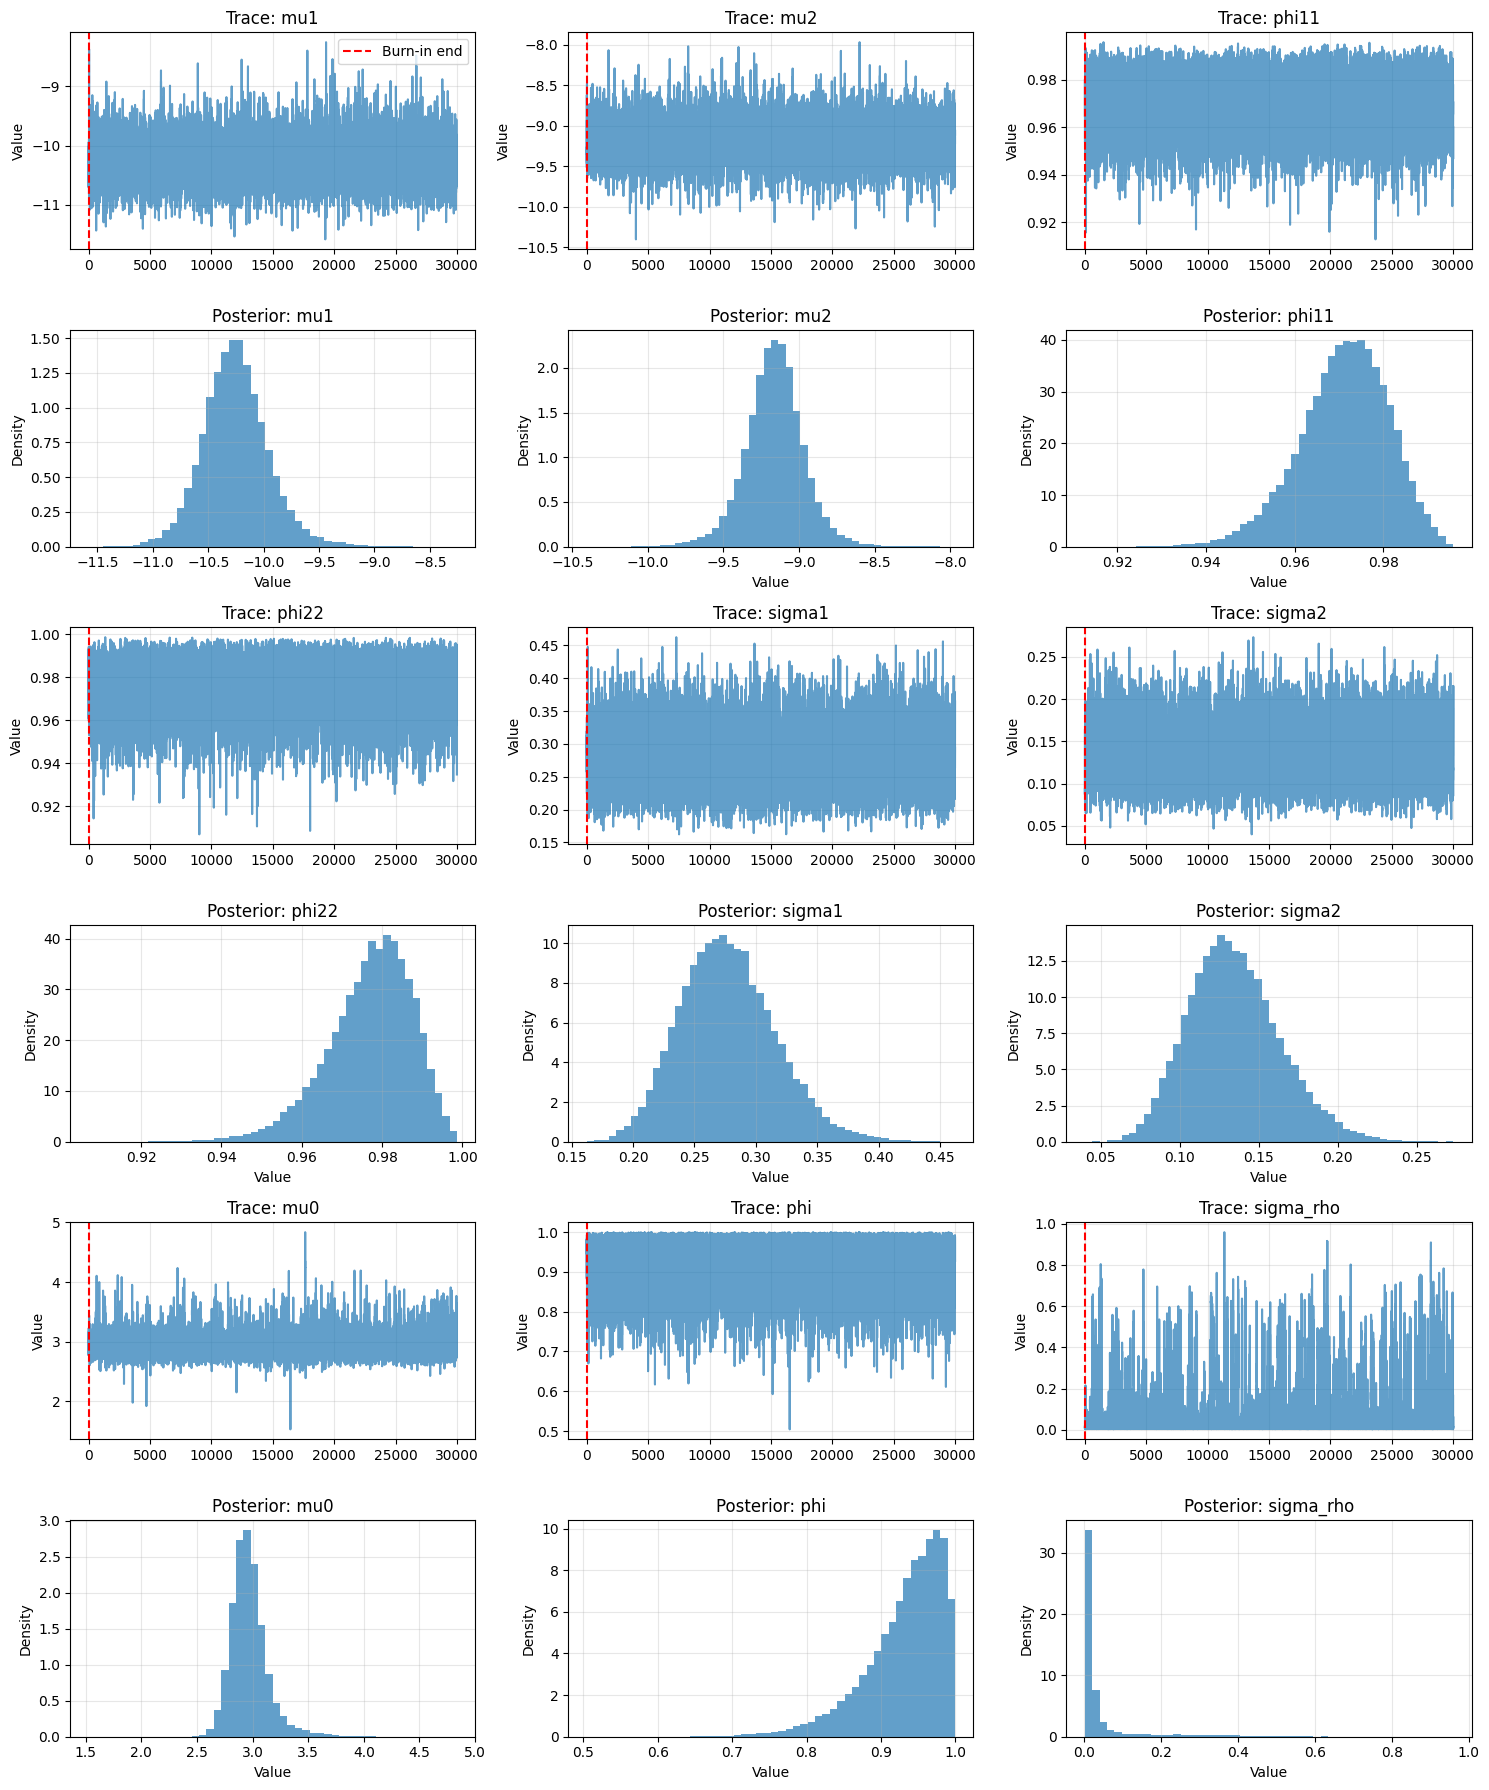

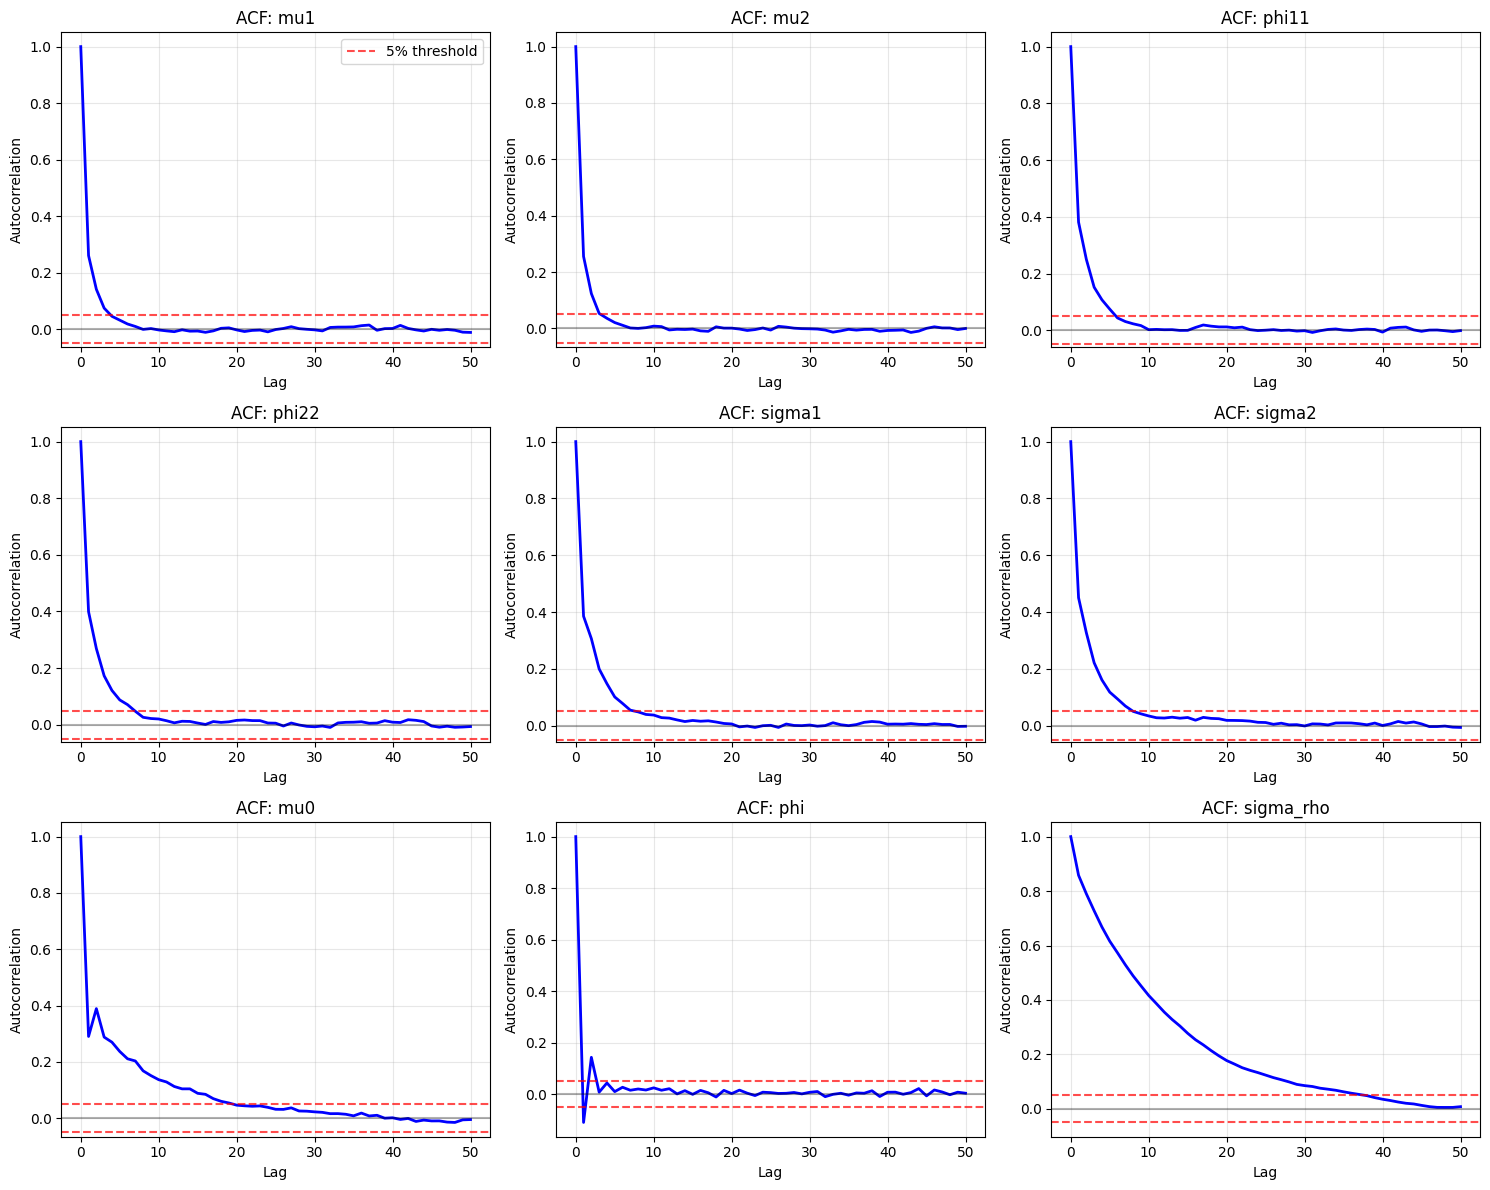


PARAMETER SUMMARY STATISTICS
------------------------------------------------------------
Parameter    Mean       Std        95% CI              
------------------------------------------------------------
mu1          -10.2521   0.3017     [-10.8191, -9.6126]
mu2          -9.1635    0.1991     [-9.5762, -8.7725]
phi11        0.9711     0.0101     [0.9489, 0.9887]
phi22        0.9768     0.0107     [0.9523, 0.9936]
sigma1       0.2774     0.0391     [0.2078, 0.3605]
sigma2       0.1347     0.0292     [0.0836, 0.1977]
mu0          2.9708     0.1766     [2.6991, 3.4049]
phi          0.9308     0.0531     [0.7970, 0.9948]
sigma_rho    0.0528     0.1051     [0.0041, 0.4091]

ADDITIONAL DIAGNOSTICS
R-hat values not available

Diagnostics completed. Average ESS: 6034


In [17]:
def plot_acf(chain, param_names, max_lags=50):
    """Plot autocorrelation function for MCMC chains"""
    n_params = len(param_names)
    n_cols = 3
    n_rows = (n_params + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten() if n_params > 1 else [axes]
    
    for i, param in enumerate(param_names):
        autocorr = acf(chain[:, i], nlags=max_lags, fft=True)
        lags = np.arange(len(autocorr))
        
        axes[i].plot(lags, autocorr, 'b-', linewidth=2)
        axes[i].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[i].axhline(y=0.05, color='r', linestyle='--', alpha=0.7, label='5% threshold')
        axes[i].axhline(y=-0.05, color='r', linestyle='--', alpha=0.7)
        axes[i].set_xlabel('Lag')
        axes[i].set_ylabel('Autocorrelation')
        axes[i].set_title(f'ACF: {param}')
        axes[i].grid(True, alpha=0.3)
        if i == 0:
            axes[i].legend()
    
    # Hide empty subplots
    for i in range(n_params, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def effective_sample_size(chain):
    """Calculate effective sample size for MCMC chains"""
    n_samples, n_params = chain.shape
    ess_values = []
    
    for i in range(n_params):
        max_lags = min(n_samples // 4, 200)
        try:
            autocorrs = acf(chain[:, i], nlags=max_lags, fft=True)
            
            # Find cutoff where autocorrelation drops below threshold
            cutoff = 1
            for lag in range(1, len(autocorrs)):
                if autocorrs[lag] <= 0.05:
                    cutoff = lag
                    break
            
            # Integrated autocorrelation time and ESS
            tau_int = 1 + 2 * np.sum(autocorrs[1:cutoff+1])
            ess = n_samples / (2 * tau_int)
            ess_values.append(max(ess, 1))
        except:
            ess_values.append(n_samples / 10)  # Conservative fallback
    
    return np.array(ess_values)

def mcmc_diagnostics_2d(chain, param_names, burned_chain):
    """Comprehensive MCMC diagnostics for DC_MSV model"""
    print("\nMCMC CONVERGENCE DIAGNOSTICS")
    print("=" * 50)
    
    n_total, n_params = chain.shape
    n_burned = len(burned_chain)
    
    print(f"Total iterations: {n_total}")
    print(f"Post-burnin samples: {n_burned}")
    
    # Effective sample size
    ess = effective_sample_size(burned_chain)
    print(f"\nEffective Sample Sizes:")
    
    # Group parameters by type
    vol_params = ['mu1', 'mu2', 'phi11', 'phi22', 'sigma1', 'sigma2']
    corr_params = ['mu0', 'phi', 'sigma_rho']
    
    print("  Volatility parameters:")
    for param in vol_params:
        if param in param_names:
            i = param_names.index(param)
            print(f"    {param}: {ess[i]:.0f} ({ess[i]/n_burned:.1%})")
    
    print("  Correlation parameters:")
    for param in corr_params:
        if param in param_names:
            i = param_names.index(param)
            print(f"    {param}: {ess[i]:.0f} ({ess[i]/n_burned:.1%})")
    
    # Create trace and density plots
    n_cols = 3
    n_rows = (n_params + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows * 2, n_cols, figsize=(15, n_rows * 6))
    
    for i, param in enumerate(param_names):
        row_trace = 2 * (i // n_cols)
        row_dens = row_trace + 1
        col = i % n_cols
        
        # Trace plot
        axes[row_trace, col].plot(chain[:, i], alpha=0.7)
        axes[row_trace, col].axvline(x=n_total-n_burned, color='r', linestyle='--', 
                                     label='Burn-in end' if i == 0 else "")
        axes[row_trace, col].set_title(f'Trace: {param}')
        axes[row_trace, col].set_ylabel('Value')
        axes[row_trace, col].grid(True, alpha=0.3)
        if i == 0:
            axes[row_trace, col].legend()
        
        # Density plot
        axes[row_dens, col].hist(burned_chain[:, i], bins=50, density=True, alpha=0.7)
        axes[row_dens, col].set_title(f'Posterior: {param}')
        axes[row_dens, col].set_xlabel('Value')
        axes[row_dens, col].set_ylabel('Density')
        axes[row_dens, col].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(n_params, n_rows * n_cols):
        for j in [0, 1]:  # Both trace and density rows
            row = 2 * (i // n_cols) + j
            col = i % n_cols
            if row < len(axes):
                axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Plot ACF
    plot_acf(burned_chain, param_names)
    
    # Summary statistics table
    print("\nPARAMETER SUMMARY STATISTICS")
    print("-" * 60)
    print(f"{'Parameter':<12} {'Mean':<10} {'Std':<10} {'95% CI':<20}")
    print("-" * 60)
    
    for i, param in enumerate(param_names):
        mean = np.mean(burned_chain[:, i])
        std = np.std(burned_chain[:, i])
        ci_low, ci_high = np.percentile(burned_chain[:, i], [2.5, 97.5])
        print(f"{param:<12} {mean:<10.4f} {std:<10.4f} [{ci_low:.4f}, {ci_high:.4f}]")
    
    return ess

def convert_numpyro_to_chain(numpyro_results):
    """Convert NumPyro results to chain format for diagnostics"""
    samples = numpyro_results['samples']
    param_names = numpyro_results['param_names']
    
    n_samples = len(samples[param_names[0]])
    n_params = len(param_names)
    
    chain = np.zeros((n_samples, n_params))
    for i, param in enumerate(param_names):
        chain[:, i] = np.array(samples[param])
    
    # NumPyro already excludes warmup
    burned_chain = chain
    return chain, burned_chain

# === RUN DIAGNOSTICS ===
print("\nRunning MCMC diagnostics...")

# Convert NumPyro results to chain format
chain, burned_chain = convert_numpyro_to_chain(results)

# Run comprehensive diagnostics
ess = mcmc_diagnostics_2d(chain, results['param_names'], burned_chain)

# NumPyro-specific diagnostics
print("\nADDITIONAL DIAGNOSTICS")
print("=" * 50)

# Try to get R-hat values
try:
    if hasattr(results['mcmc'], 'get_extra_fields'):
        r_hat = results['mcmc'].get_extra_fields().get('r_hat', {})
        if r_hat:
            print("Gelman-Rubin R-hat values:")
            for param in results['param_names']:
                if param in r_hat:
                    print(f"  {param}: {r_hat[param]:.3f}")
        else:
            print("R-hat values not available")
    else:
        print("R-hat values not available (single chain)")
except Exception as e:
    print(f"R-hat calculation error: {e}")

print(f"\nDiagnostics completed. Average ESS: {np.mean(ess):.0f}")

## GARCH(1,1) 2d estimation

In [18]:
# === CCC-GARCH(1,1) with constant correlation (Bollerslev, 1990) ===
# Likelihood: y_t ~ N(0, H_t),  H_t = diag(h1_t, h2_t) @ R @ diag(h1_t, h2_t)
# with h_it = ω_i + α_i y_{i,t-1}^2 + β_i h_{i,t-1}, i = 1,2 and R = [[1, ρ],[ρ,1]]

import jax
import jax.numpy as jnp
from jax import lax
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

def numpyro_estimation_ccc_garch11(returns_array, n_iter=10000, n_warmup=2000, n_chains=2):
    """
    HMC estimation for bivariate CCC-GARCH(1,1) with constant correlation.

    Args:
        returns_array: (T, 2) array of returns (in decimal, e.g., 0.01 = 1%)
        n_iter: total iterations per chain
        n_warmup: warmup iterations
        n_chains: number of chains
    Returns:
        dict with mcmc object, posterior samples, and parameter summaries
    """
    jax.config.update("jax_platform_name", "cpu")

    y = jnp.asarray(returns_array)
    T = y.shape[0]

    def ccc_garch_model(y=None):
        # --- Data-informed scale for unconditional variances ---
        # Use sample variances as a rough scale for vbar_i
        s2 = jnp.var(y, axis=0) + 1e-8  # shape (2,)

        # --- Parameterization that enforces α_i, β_i >= 0 and α_i + β_i < 1 ---
        # Stick-breaking: let κ in (0,1); then α_i = κ * u_i, β_i = κ * (1 - u_i) * v_i
        kappa = 0.999
        u1 = numpyro.sample("u1", dist.Beta(2., 2.))
        v1 = numpyro.sample("v1", dist.Beta(2., 2.))
        u2 = numpyro.sample("u2", dist.Beta(2., 2.))
        v2 = numpyro.sample("v2", dist.Beta(2., 2.))

        alpha1 = numpyro.deterministic("alpha1", kappa * u1)
        beta1  = numpyro.deterministic("beta1",  kappa * (1. - u1) * v1)
        alpha2 = numpyro.deterministic("alpha2", kappa * u2)
        beta2  = numpyro.deterministic("beta2",  kappa * (1. - u2) * v2)

        # Unconditional variance vbar_i > 0; set ω_i = vbar_i * (1 - α_i - β_i)
        # HalfNormal prior centered on sample variance scale
        vbar1 = numpyro.sample("vbar1", dist.HalfNormal(jnp.sqrt(s2[0]) + 1e-6)) ** 2
        vbar2 = numpyro.sample("vbar2", dist.HalfNormal(jnp.sqrt(s2[1]) + 1e-6)) ** 2
        omega1 = numpyro.deterministic("omega1", vbar1 * (1. - alpha1 - beta1))
        omega2 = numpyro.deterministic("omega2", vbar2 * (1. - alpha2 - beta2))

        # Constant correlation ρ ∈ (-1,1): use tanh transform of Normal
        rho_uncon = numpyro.sample("rho_uncon", dist.Normal(0., 1.))
        rho = numpyro.deterministic("rho", jnp.tanh(rho_uncon) * 0.98)  # keep away from ±1 for stability

        # --- Variance recursion via lax.scan ---
        # Initialize at unconditional variance
        h1_0 = numpyro.deterministic("h1_0", vbar1)
        h2_0 = numpyro.deterministic("h2_0", vbar2)

        def step(carry, yt_prev):
            h1_prev, h2_prev = carry
            # yt_prev is y_{t-1}, shape (2,)
            y1_sq = yt_prev[0] ** 2
            y2_sq = yt_prev[1] ** 2

            h1_t = omega1 + alpha1 * y1_sq + beta1 * h1_prev
            h2_t = omega2 + alpha2 * y2_sq + beta2 * h2_prev
            return (h1_t, h2_t), jnp.stack([h1_t, h2_t])

        # We need y_{t-1} for t=1..T-1; define y_lag with y_0 as zeros or sample mean
        y0 = jnp.zeros(2)
        y_lag = jnp.vstack([y0[None, :], y[:-1, :]])  # shape (T,2)

        (_, _), h_seq = lax.scan(step, (h1_0, h2_0), y_lag)  # h_seq shape (T,2)
        h1 = numpyro.deterministic("h1", h_seq[:, 0] + 1e-12)
        h2 = numpyro.deterministic("h2", h_seq[:, 1] + 1e-12)

        # --- Build H_t for all t and vectorized MVN likelihood ---
        # Off-diagonal: ρ * sqrt(h1_t * h2_t)
        cov12 = rho * jnp.sqrt(h1 * h2)

        covs = jnp.zeros((T, 2, 2))
        covs = covs.at[:, 0, 0].set(h1)
        covs = covs.at[:, 1, 1].set(h2)
        covs = covs.at[:, 0, 1].set(cov12)
        covs = covs.at[:, 1, 0].set(cov12)

        # Regularization for numerical stability
        covs = covs + 1e-10 * jnp.eye(2)[None, :, :]

        with numpyro.plate("obs", T):
            numpyro.sample("y", dist.MultivariateNormal(loc=jnp.zeros(2), covariance_matrix=covs), obs=y)

    print(f"Running CCC-GARCH(1,1) estimation ({n_chains} chains, {n_iter} iterations each)...")
    nuts = NUTS(ccc_garch_model)
    mcmc = MCMC(nuts, num_warmup=n_warmup, num_samples=n_iter - n_warmup,
                num_chains=n_chains, progress_bar=True)
    mcmc.run(jax.random.PRNGKey(1), y=y)

    samples = mcmc.get_samples()

    # Summaries
    params = ["omega1","alpha1","beta1","vbar1","omega2","alpha2","beta2","vbar2","rho"]
    summaries = {}
    for p in params:
        ps = samples[p]
        summaries[p] = {
            "mean": float(jnp.mean(ps)),
            "std": float(jnp.std(ps)),
            "q025": float(jnp.quantile(ps, 0.025)),
            "q500": float(jnp.quantile(ps, 0.500)),
            "q975": float(jnp.quantile(ps, 0.975)),
        }

    print("CCC-GARCH(1,1) NumPyro estimation completed")
    print("\nParameter Estimates (Posterior Means):")
    print("-" * 50)
    for p in params:
        est = summaries[p]
        print(f"{p:>7}: {est['mean']: .6f} ± {est['std']: .6f}")

    return {"mcmc": mcmc, "samples": samples, "estimates": summaries, "param_names": params}

# === Example call (mirrors your pipeline) ===
# Convert to decimal if you followed the same data prep:
train_array_decimal = train_array / 100
results_ccc = numpyro_estimation_ccc_garch11(train_array_decimal, n_iter=20000, n_warmup=5000)


Running CCC-GARCH(1,1) estimation (2 chains, 20000 iterations each)...


sample: 100%|██████████| 20000/20000 [00:21<00:00, 947.17it/s, 7 steps of size 3.03e-01. acc. prob=0.93] 


CCC-GARCH(1,1) NumPyro estimation completed

Parameter Estimates (Posterior Means):
--------------------------------------------------
 omega1:  0.000005 ±  0.000001
 alpha1:  0.167861 ±  0.021249
  beta1:  0.751846 ±  0.026602
  vbar1:  0.008281 ±  0.000604
 omega2:  0.000014 ±  0.000004
 alpha2:  0.123736 ±  0.020516
  beta2:  0.775552 ±  0.038361
  vbar2:  0.011786 ±  0.000572
    rho:  0.753302 ±  0.012531



Running MCMC diagnostics for GARCH(1,1)...

MCMC CONVERGENCE DIAGNOSTICS
Total iterations: 30000
Post-burnin samples: 30000

Effective Sample Sizes:
  Volatility parameters:
    omega1: 27554 (91.8%)
    alpha1: 20051 (66.8%)
    beta1: 24322 (81.1%)
    omega2: 23517 (78.4%)
    alpha2: 21240 (70.8%)
    beta2: 21232 (70.8%)
  Correlation parameters:
    rho: 21906 (73.0%)
  Other:
    vbar1: 13747 (45.8%)
    vbar2: 16107 (53.7%)


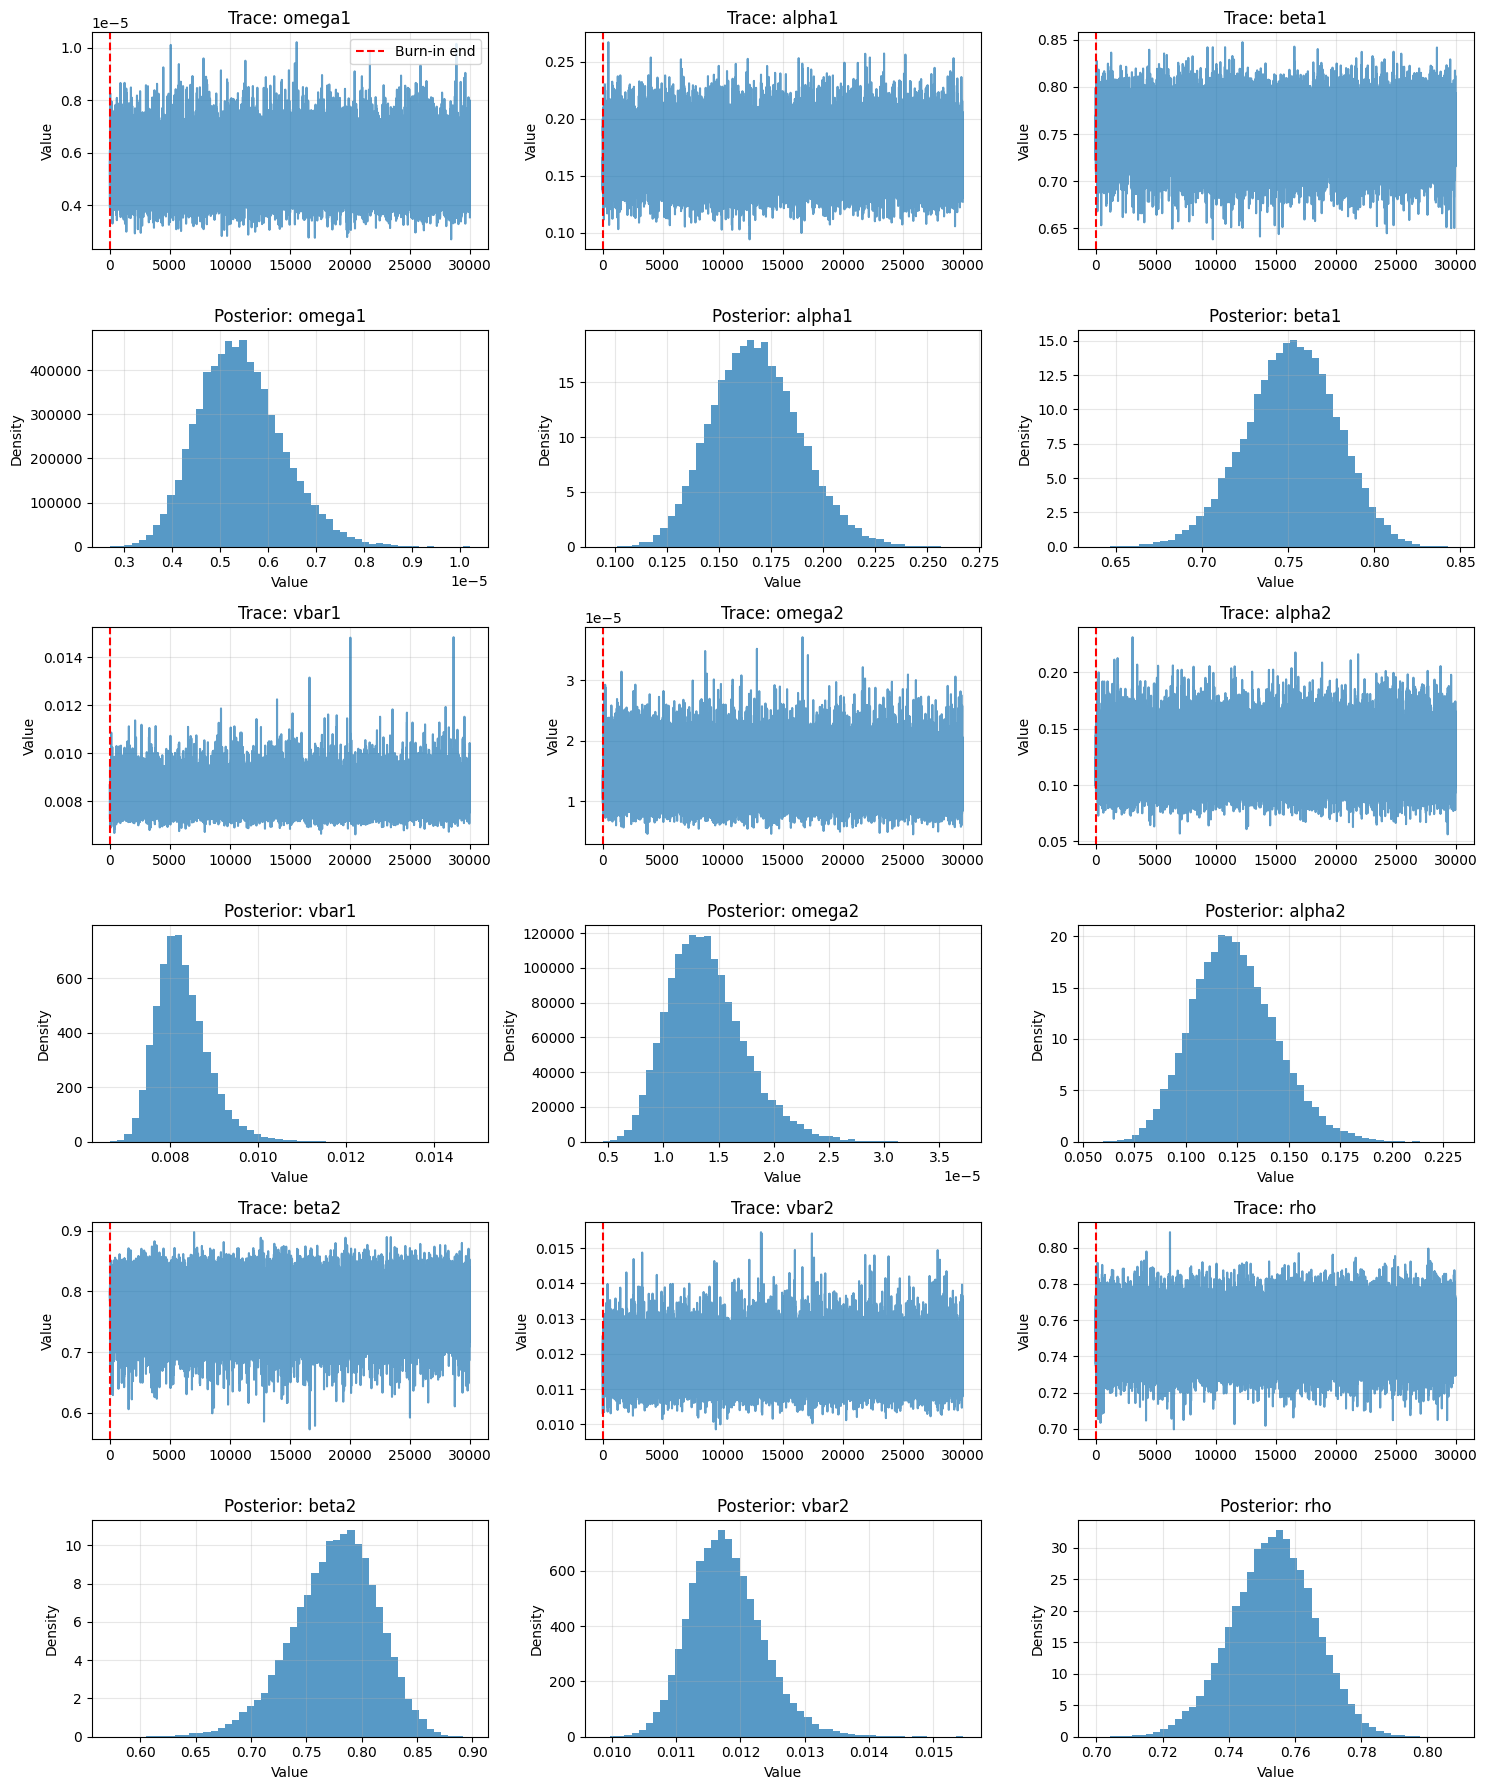

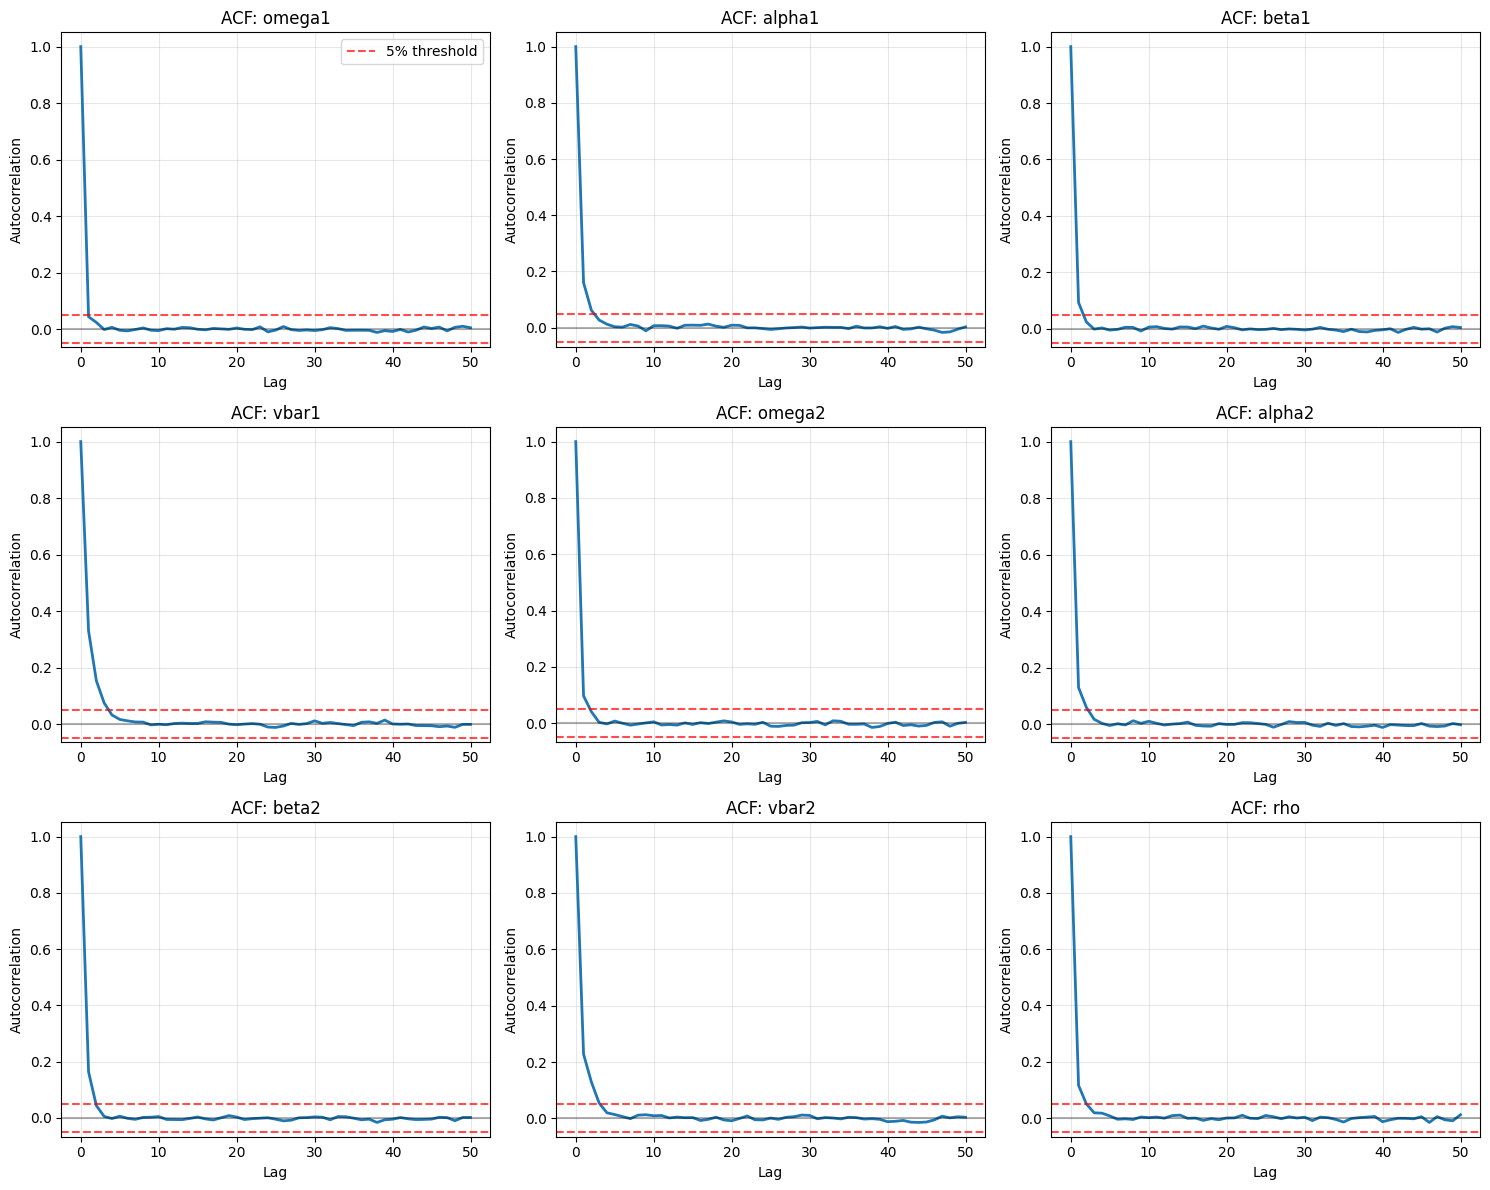


PARAMETER SUMMARY STATISTICS
------------------------------------------------------------
Parameter      Mean       Std        95% CI                
------------------------------------------------------------
omega1         0.0000     0.0000     [0.0000, 0.0000]
alpha1         0.1679     0.0212     [0.1290, 0.2123]
beta1          0.7518     0.0266     [0.6978, 0.8014]
vbar1          0.0083     0.0006     [0.0073, 0.0097]
omega2         0.0000     0.0000     [0.0000, 0.0000]
alpha2         0.1237     0.0205     [0.0870, 0.1672]
beta2          0.7756     0.0384     [0.6928, 0.8431]
vbar2          0.0118     0.0006     [0.0108, 0.0130]
rho            0.7533     0.0125     [0.7278, 0.7769]

ADDITIONAL DIAGNOSTICS
R-hat extraction error: name 'garch_results' is not defined

Diagnostics completed. Average ESS: 21075


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# ==============================
#   MCMC Diagnostics (GARCH)
# ==============================

def plot_acf(chain, param_names, max_lags=50):
    """Plot autocorrelation function for MCMC chains."""
    n_params = len(param_names)
    n_cols = 3
    n_rows = (n_params + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten() if n_params > 1 else [axes]

    for i, param in enumerate(param_names):
        autocorr = acf(chain[:, i], nlags=max_lags, fft=True)
        lags = np.arange(len(autocorr))

        axes[i].plot(lags, autocorr, linewidth=2)
        axes[i].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[i].axhline(y=0.05, color='r', linestyle='--', alpha=0.7, label='5% threshold')
        axes[i].axhline(y=-0.05, color='r', linestyle='--', alpha=0.7)
        axes[i].set_xlabel('Lag')
        axes[i].set_ylabel('Autocorrelation')
        axes[i].set_title(f'ACF: {param}')
        axes[i].grid(True, alpha=0.3)
        if i == 0:
            axes[i].legend()

    # Hide empty subplots
    for i in range(n_params, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()


def effective_sample_size(chain):
    """Calculate effective sample size for MCMC chains using a simple cutoff rule."""
    n_samples, n_params = chain.shape
    ess_values = []

    for i in range(n_params):
        max_lags = min(n_samples // 4, 200)
        try:
            autocorrs = acf(chain[:, i], nlags=max_lags, fft=True)

            # Cutoff where autocorr first drops below 0.05 in magnitude
            cutoff = 1
            for lag in range(1, len(autocorrs)):
                if np.abs(autocorrs[lag]) <= 0.05:
                    cutoff = lag
                    break

            tau_int = 1 + 2 * np.sum(autocorrs[1:cutoff+1])
            ess = n_samples / max(tau_int, 1e-6)
            ess_values.append(max(ess, 1.0))
        except Exception:
            ess_values.append(n_samples / 10.0)  # conservative fallback

    return np.array(ess_values)


def mcmc_diagnostics_garch(chain, param_names, burned_chain):
    """Comprehensive MCMC diagnostics for 2D GARCH(1,1) estimation."""
    print("\nMCMC CONVERGENCE DIAGNOSTICS")
    print("=" * 50)

    n_total, n_params = chain.shape
    n_burned = len(burned_chain)

    print(f"Total iterations: {n_total}")
    print(f"Post-burnin samples: {n_burned}")

    # Effective sample size
    ess = effective_sample_size(burned_chain)
    print(f"\nEffective Sample Sizes:")
    # Heuristic grouping for typical 2D GARCH params
    vol_params = [p for p in param_names if any(k in p.lower() for k in ['omega', 'alpha', 'beta'])]
    corr_params = [p for p in param_names if any(k in p.lower() for k in ['rho', 'dcc', 'a12', 'b12'])]
    other_params = [p for p in param_names if p not in vol_params + corr_params]

    def _print_group(title, names):
        if names:
            print(f"  {title}:")
            for p in names:
                i = param_names.index(p)
                print(f"    {p}: {ess[i]:.0f} ({ess[i]/n_burned:.1%})")

    _print_group("Volatility parameters", vol_params)
    _print_group("Correlation parameters", corr_params)
    _print_group("Other", other_params)

    # Trace + density plots
    n_cols = 3
    n_rows = (n_params + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows * 2, n_cols, figsize=(15, n_rows * 6))
    axes = np.atleast_2d(axes)

    for i, param in enumerate(param_names):
        row_trace = 2 * (i // n_cols)
        row_dens = row_trace + 1
        col = i % n_cols

        # Trace
        axes[row_trace, col].plot(chain[:, i], alpha=0.7)
        axes[row_trace, col].axvline(x=n_total - n_burned, color='r', linestyle='--',
                                     label='Burn-in end' if i == 0 else "")
        axes[row_trace, col].set_title(f'Trace: {param}')
        axes[row_trace, col].set_ylabel('Value')
        axes[row_trace, col].grid(True, alpha=0.3)
        if i == 0:
            axes[row_trace, col].legend()

        # Posterior histogram
        axes[row_dens, col].hist(burned_chain[:, i], bins=50, density=True, alpha=0.75)
        axes[row_dens, col].set_title(f'Posterior: {param}')
        axes[row_dens, col].set_xlabel('Value')
        axes[row_dens, col].set_ylabel('Density')
        axes[row_dens, col].grid(True, alpha=0.3)

    # Hide empties
    total_axes = n_rows * 2 * n_cols
    for idx in range(n_params, (total_axes // 2)):
        r1 = 2 * (idx // n_cols)
        c1 = idx % n_cols
        r2 = r1 + 1
        if r1 < axes.shape[0]:
            axes[r1, c1].set_visible(False)
        if r2 < axes.shape[0]:
            axes[r2, c1].set_visible(False)

    plt.tight_layout()
    plt.show()

    # ACF plots
    plot_acf(burned_chain, param_names)

    # Summary table
    print("\nPARAMETER SUMMARY STATISTICS")
    print("-" * 60)
    print(f"{'Parameter':<14} {'Mean':<10} {'Std':<10} {'95% CI':<22}")
    print("-" * 60)
    for i, param in enumerate(param_names):
        mean = np.mean(burned_chain[:, i])
        std = np.std(burned_chain[:, i])
        ci_low, ci_high = np.percentile(burned_chain[:, i], [2.5, 97.5])
        print(f"{param:<14} {mean:<10.4f} {std:<10.4f} [{ci_low:.4f}, {ci_high:.4f}]")

    return ess


def convert_numpyro_to_chain(numpyro_results):
    """Convert NumPyro results to (chain, burned_chain) format for diagnostics."""
    samples = numpyro_results['samples']
    param_names = numpyro_results['param_names']

    n_samples = len(samples[param_names[0]])
    n_params = len(param_names)

    chain = np.zeros((n_samples, n_params))
    for i, param in enumerate(param_names):
        chain[:, i] = np.array(samples[param])

    # NumPyro stores post-warmup; nothing to drop here
    burned_chain = chain
    return chain, burned_chain


# ==============================
#   RUN DIAGNOSTICS
# ==============================
print("\nRunning MCMC diagnostics for GARCH(1,1)...")

# Convert NumPyro results to chain format
garch_chain, garch_burned = convert_numpyro_to_chain(results_ccc)
param_names = results_ccc['param_names']

# Run comprehensive diagnostics
garch_ess = mcmc_diagnostics_garch(garch_chain, param_names, garch_burned)

# NumPyro-specific extras (R-hat if present)
print("\nADDITIONAL DIAGNOSTICS")
print("=" * 50)
try:
    if hasattr(garch_results['mcmc'], 'get_extra_fields'):
        r_hat = garch_results['mcmc'].get_extra_fields().get('r_hat', {})
        if r_hat:
            print("Gelman-Rubin R-hat values:")
            for p in param_names:
                if p in r_hat:
                    print(f"  {p}: {float(r_hat[p]):.3f}")
        else:
            print("R-hat values not available")
    else:
        print("R-hat values not available (interface does not expose extra fields)")
except Exception as e:
    print(f"R-hat extraction error: {e}")

print(f"\nDiagnostics completed. Average ESS: {np.mean(garch_ess):.0f}")


## 4. Model Evaluation: Out-of-Sample Performance

### Negative Log Predictive Density (NLPD) Comparison

Evaluate model performance using particle filtering on the test set to compute predictive likelihoods.

### Online Filtering and Robust Model Comparison

In [13]:
from particles_cdssm.collectors import NLPD
from scipy.stats import gaussian_kde
import numpy as np

class NLPD_Diagnostic(NLPD):
    """
    Standard NLPD with diagnostic tracking for spike analysis.
    No capping, no cooking - just honest evaluation with logging.
    """
    def __init__(self, spike_threshold=10.0, **kwargs):
        super().__init__(**kwargs)
        self.spike_threshold = spike_threshold
        self.time_step = -1  # Will be incremented to 0 on first call
        self.spike_info = []  # Store info about spikes
        
    def out_func_Y(self, wgts, Y):
        """Returns honest NLPD with diagnostic tracking."""
        if not self.has_y_true:
            return None
        
        self.time_step += 1
        
        # Standard NLPD calculation
        W = wgts.W if not self.rs_flag else None
        kde = gaussian_kde(Y.T, weights=W)
        log_p = kde.logpdf(self.y_true)
        
        if isinstance(log_p, np.ndarray):
            log_p = float(log_p.item())
            
        nlpd = -1. * log_p
        
        # Track spikes for later analysis (but don't modify the value!)
        if nlpd > self.spike_threshold:
            spike_data = {
                'time_step': self.time_step,
                'nlpd': float(nlpd),
                'observation': self.y_true.copy() if hasattr(self.y_true, 'copy') else self.y_true,
                'particle_mean': np.mean(Y, axis=0),
                'particle_std': np.std(Y, axis=0),
                'particle_min': np.min(Y, axis=0),
                'particle_max': np.max(Y, axis=0),
                'num_particles': len(Y)
            }
            self.spike_info.append(spike_data)
            
        return nlpd  # Return honest value

🔄 NLPD COMPARISON USING PARTICLE PREDICTIONS

1. Running particle filters with 1000 particles...
   ✅ DC-MSV particle filter completed
   ✅ Bivariate particle filter completed

2. Extracting NLPD values from collectors...
   📊 DC-MSV raw NLPD length: 530
   📊 Bivariate raw NLPD length: 530
   ✅ Successfully extracted NLPD values
   📊 DC-MSV NLPD shape: (528,)
   📊 Bivariate NLPD shape: (528,)

🔍 SPIKE ANALYSIS FOR DC-MSV MODEL

🔍 SPIKE ANALYSIS FOR DC-MSV MODEL
No spikes found above threshold

📊 DETAILED SPIKE ANALYSIS
--------------------------------------------------------------------------------

3. Computing NLPD statistics...

DC-MSV Model:
  Mean NLPD:    -6.1769
  Median NLPD:  -6.6820
  Std NLPD:     2.0397
  Min/Max:      -8.76 / 9.68
  Observations: 528

Bivariate Model:
  Mean NLPD:    -1.4971
  Median NLPD:  -6.9342
  Std NLPD:     36.2256
  Min/Max:      -7.78 / 530.46
  Observations: 528

📊 MODEL COMPARISON SUMMARY:
--------------------------------------------------
Mean 

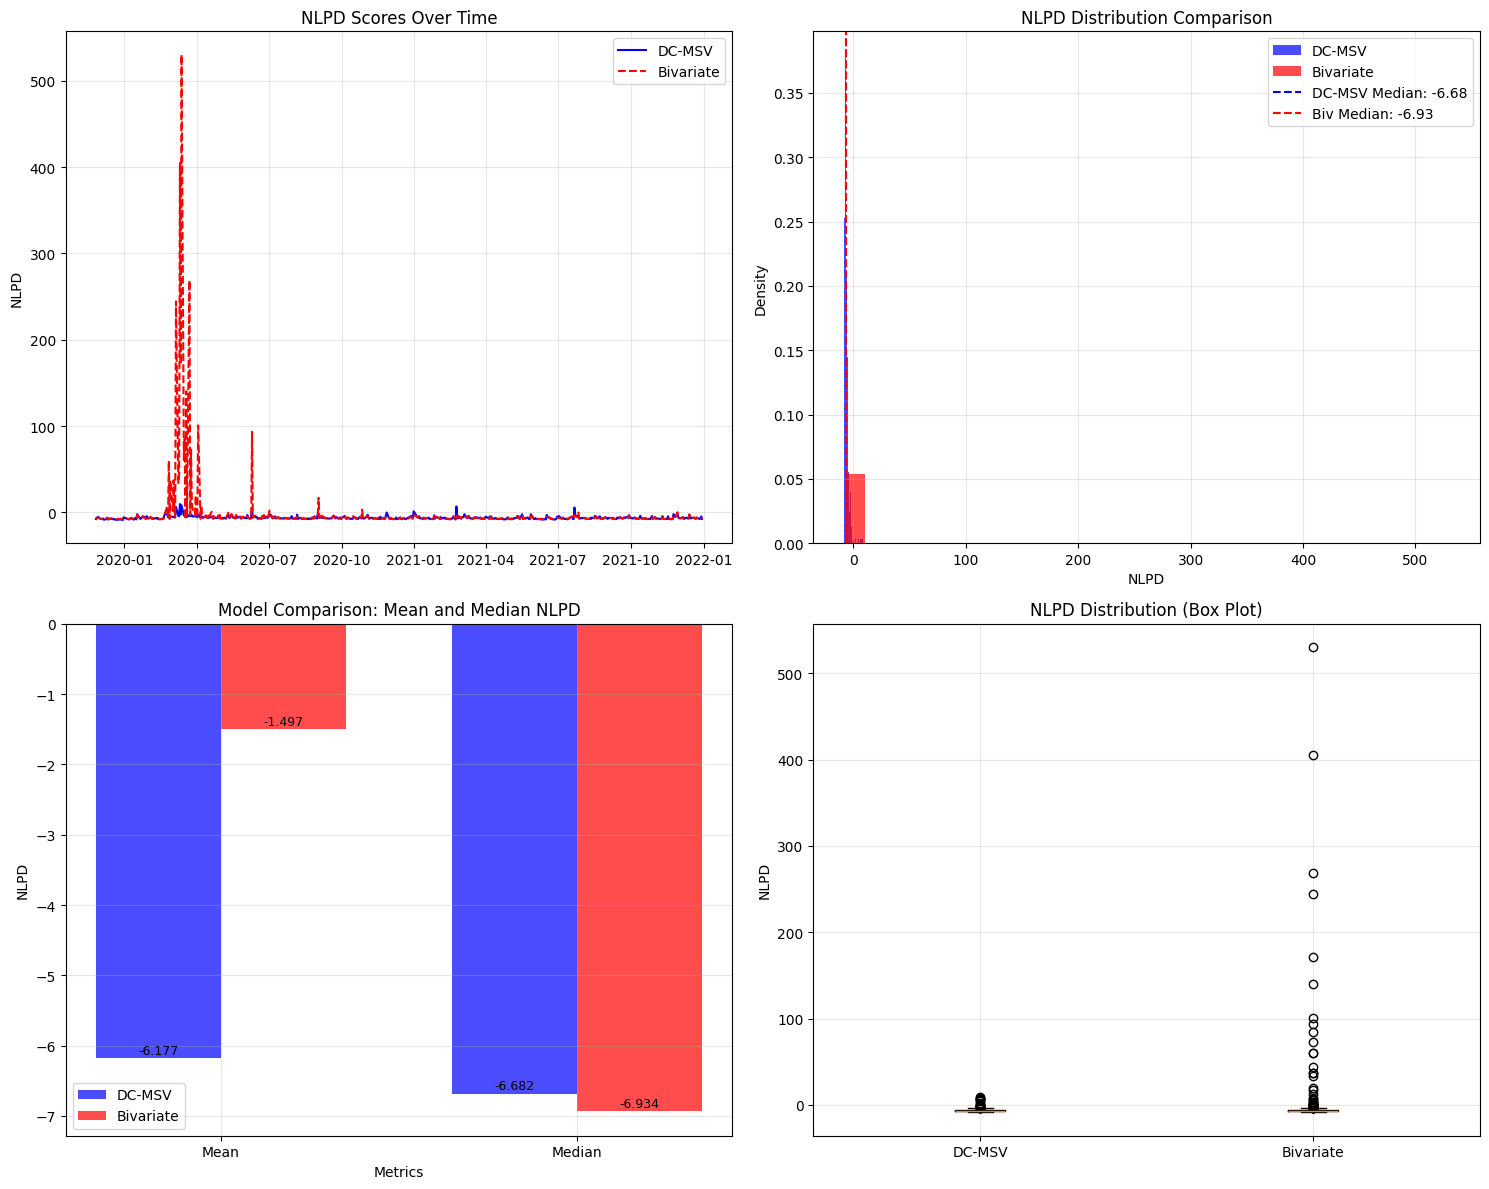

✅ NLPD comparison completed using particle predictions and collector!


In [14]:
# === NLPD COMPARISON USING PARTICLE PREDICTIONS ===
print("🔄 NLPD COMPARISON USING PARTICLE PREDICTIONS")
print("=" * 50)

# Initialize models with estimated parameters
params = results['estimates']
dc_msv_model = DC_MSV(
    mu1=params['mu1']['mean'], mu2=params['mu2']['mean'],
    phi11=params['phi11']['mean'], phi22=params['phi22']['mean'],
    sigma_eta1=params['sigma1']['mean'], sigma_eta2=params['sigma2']['mean'],
    psi0=params['mu0']['mean'], psi=params['phi']['mean'],
    sigma_rho=params['sigma_rho']['mean']
)

bivariate_model = BivariateNormal(train_array_decimal)

# Set up particle filters
N = 1000  # Number of particles
np.random.seed(42)  # For reproducibility

print(f"\n1. Running particle filters with {N} particles...")

# DC-MSV particle filter
fk_dc = Bootstrap(ssm=dc_msv_model, data=test_array_decimal)
# Use mixture NLPD for DC-MSV to prevent spikes
# Create the collector and then set up baseline parameters
# Use higher mixture weight for more insurance
baseline_mean = np.mean(train_array_decimal, axis=0)
baseline_cov = np.cov(train_array_decimal.T)
# Very strict adaptive capping
nlpd_collector_dc = NLPD_Diagnostic(spike_threshold=10.0)
smc_dc = particles.SMC(fk=fk_dc, N=N, collect=[nlpd_collector_dc])
smc_dc.run()

print("   ✅ DC-MSV particle filter completed")

# Bivariate particle filter  
fk_biv = Bootstrap(ssm=bivariate_model, data=test_array_decimal)
nlpd_collector_biv = NLPD()
smc_biv = particles.SMC(fk=fk_biv, N=N, collect=[nlpd_collector_biv])
smc_biv.run()

print("   ✅ Bivariate particle filter completed")

# Extract NLPD values using your friend's collector
print(f"\n2. Extracting NLPD values from collectors...")

# The NLPD collector stores values as [None, array1, array2, ...] where None is at t=0
try:
    # Extract from smc summaries
    nlpd_dc_raw = smc_dc.summaries.nlpd
    nlpd_biv_raw = smc_biv.summaries.nlpd
    
    print(f"   📊 DC-MSV raw NLPD length: {len(nlpd_dc_raw)}")
    print(f"   📊 Bivariate raw NLPD length: {len(nlpd_biv_raw)}")
    
    # Convert to arrays, skipping None values and extracting scalars from arrays
    nlpd_dc_values = []
    for i, val in enumerate(nlpd_dc_raw):
        if val is not None:
            if isinstance(val, np.ndarray):
                nlpd_dc_values.append(float(val.item()))  # Extract scalar from array
            else:
                nlpd_dc_values.append(float(val))
    
    nlpd_biv_values = []
    for i, val in enumerate(nlpd_biv_raw):
        if val is not None:
            if isinstance(val, np.ndarray):
                nlpd_biv_values.append(float(val.item()))  # Extract scalar from array
            else:
                nlpd_biv_values.append(float(val))
    
    nlpd_dc_array = np.array(nlpd_dc_values)
    nlpd_biv_array = np.array(nlpd_biv_values)
    
    print(f"   ✅ Successfully extracted NLPD values")
    print(f"   📊 DC-MSV NLPD shape: {nlpd_dc_array.shape}")
    print(f"   📊 Bivariate NLPD shape: {nlpd_biv_array.shape}")
    
    print(f"\n🔍 SPIKE ANALYSIS FOR DC-MSV MODEL")
    print(f"\n🔍 SPIKE ANALYSIS FOR DC-MSV MODEL")
    spike_threshold = 10.0
    spike_indices = np.where(nlpd_dc_array > spike_threshold)[0]

    if len(spike_indices) > 0:
        print(f"Found {len(spike_indices)} spikes with NLPD > {spike_threshold}")
        print("-" * 80)
        
        for idx in spike_indices:
            spike_date = test_df.index[idx]
            spike_value = nlpd_dc_array[idx]
            
            print(f"\nSpike at {spike_date}:")
            print(f"  NLPD value: {spike_value:.2f}")
            print(f"  Test data at this date: {test_array_decimal[idx]}")
            
            # Also show surrounding days for context
            if idx > 0:
                print(f"  Previous day NLPD: {nlpd_dc_array[idx-1]:.2f}")
            if idx < len(nlpd_dc_array) - 1:
                print(f"  Next day NLPD: {nlpd_dc_array[idx+1]:.2f}")
    else:
        print("No spikes found above threshold")
    
    # Deeper analysis of the spike
    print(f"\n📊 DETAILED SPIKE ANALYSIS")
    print("-" * 80)

    # Calculate what the model might have been expecting
    for idx in spike_indices:
        print(f"\nAnalyzing spike at index {idx} ({test_df.index[idx]}):")
        
        # Look at the data around the spike
        window = 5  # days before and after
        start_idx = max(0, idx - window)
        end_idx = min(len(test_array_decimal), idx + window + 1)
        
        print(f"\n  Returns around the spike:")
        for i in range(start_idx, end_idx):
            marker = " <-- SPIKE" if i == idx else ""
            print(f"    {test_df.index[i]}: {test_array_decimal[i]}{marker}")
        
        # Calculate correlation in surrounding window
        if idx >= 10:
            pre_spike_data = test_array_decimal[idx-10:idx]
            pre_spike_corr = np.corrcoef(pre_spike_data[:, 0], pre_spike_data[:, 1])[0, 1]
            print(f"\n  Correlation (10 days before): {pre_spike_corr:.3f}")
        
        # Look at volatilities
        if idx >= 20:
            pre_spike_vol = np.std(test_array_decimal[idx-20:idx], axis=0)
            print(f"  Volatilities (20 days before): {pre_spike_vol}")
            print(f"  Actual returns at spike: {test_array_decimal[idx]}")
            print(f"  Standardized returns: {test_array_decimal[idx] / pre_spike_vol}")
    
    if len(nlpd_dc_array) == 0 or len(nlpd_biv_array) == 0:
        raise ValueError("No valid NLPD values extracted")
        
except Exception as e:
    print(f"   ❌ Error extracting NLPD: {e}")
    print("   🚨 Cannot proceed with NLPD comparison")
    raise

# After extracting NLPD values but before computing statistics
if hasattr(nlpd_collector_dc, 'spike_info') and len(nlpd_collector_dc.spike_info) > 0:
    print(f"\n🔍 SPIKE ANALYSIS FOR DC-MSV MODEL")
    print(f"Found {len(nlpd_collector_dc.spike_info)} spikes with NLPD > 10")
    print("-" * 80)
    
    for i, spike in enumerate(nlpd_collector_dc.spike_info):
        # Convert time_step to actual date
        spike_date = test_df.index[spike['time_step']]
        
        print(f"\nSpike {i+1} at {spike_date}:")
        print(f"  NLPD value: {spike['nlpd']:.2f}")
        print(f"  Observed values: {spike['observation']}")
        print(f"  Particle mean: {spike['particle_mean']}")
        print(f"  Particle std: {spike['particle_std']}")
        print(f"  Particle range: [{spike['particle_min']}, {spike['particle_max']}]")
        
        # Show how far the observation was from particle predictions
        z_scores = (spike['observation'] - spike['particle_mean']) / spike['particle_std']
        print(f"  Z-scores: {z_scores}")

# Compute statistics
print(f"\n3. Computing NLPD statistics...")

# DC-MSV statistics
stats_dc = {
    'mean': np.mean(nlpd_dc_array),
    'std': np.std(nlpd_dc_array),
    'median': np.median(nlpd_dc_array),
    'min': np.min(nlpd_dc_array),
    'max': np.max(nlpd_dc_array),
    'n_obs': len(nlpd_dc_array)
}

# Bivariate statistics
stats_biv = {
    'mean': np.mean(nlpd_biv_array),
    'std': np.std(nlpd_biv_array),
    'median': np.median(nlpd_biv_array),
    'min': np.min(nlpd_biv_array),
    'max': np.max(nlpd_biv_array),
    'n_obs': len(nlpd_biv_array)
}

print(f"\nDC-MSV Model:")
print(f"  Mean NLPD:    {stats_dc['mean']:.4f}")
print(f"  Median NLPD:  {stats_dc['median']:.4f}")
print(f"  Std NLPD:     {stats_dc['std']:.4f}")
print(f"  Min/Max:      {stats_dc['min']:.2f} / {stats_dc['max']:.2f}")
print(f"  Observations: {stats_dc['n_obs']}")

print(f"\nBivariate Model:")
print(f"  Mean NLPD:    {stats_biv['mean']:.4f}")
print(f"  Median NLPD:  {stats_biv['median']:.4f}")
print(f"  Std NLPD:     {stats_biv['std']:.4f}")
print(f"  Min/Max:      {stats_biv['min']:.2f} / {stats_biv['max']:.2f}")
print(f"  Observations: {stats_biv['n_obs']}")

# Model comparison
mean_diff = stats_dc['mean'] - stats_biv['mean']
median_diff = stats_dc['median'] - stats_biv['median']

print(f"\n📊 MODEL COMPARISON SUMMARY:")
print("-" * 50)
print(f"Mean NLPD Difference (DC-MSV - Bivariate): {mean_diff:.4f}")
print(f"Median NLPD Difference:                    {median_diff:.4f}")

if mean_diff < 0:
    print(f"✅ DC-MSV performs better by {abs(mean_diff):.4f} NLPD points")
else:
    print(f"❌ Bivariate performs better by {mean_diff:.4f} NLPD points")

# Visualization
print(f"\n4. Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Time series comparison
dates = test_df.index[:len(nlpd_dc_array)]
axes[0,0].plot(dates, nlpd_dc_array, label='DC-MSV', color='blue', linewidth=1.5)
axes[0,0].plot(dates, nlpd_biv_array, label='Bivariate', color='red', linestyle='--', linewidth=1.5)
axes[0,0].set_title('NLPD Scores Over Time')
axes[0,0].set_ylabel('NLPD')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Histogram comparison
axes[0,1].hist(nlpd_dc_array, bins=30, alpha=0.7, color='blue', density=True, label='DC-MSV')
axes[0,1].hist(nlpd_biv_array, bins=30, alpha=0.7, color='red', density=True, label='Bivariate')
axes[0,1].axvline(stats_dc['median'], color='blue', linestyle='--', label=f'DC-MSV Median: {stats_dc["median"]:.2f}')
axes[0,1].axvline(stats_biv['median'], color='red', linestyle='--', label=f'Biv Median: {stats_biv["median"]:.2f}')
axes[0,1].set_title('NLPD Distribution Comparison')
axes[0,1].set_xlabel('NLPD')
axes[0,1].set_ylabel('Density')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Bar chart comparison
metrics = ['Mean', 'Median']
dc_values = [stats_dc['mean'], stats_dc['median']]
biv_values = [stats_biv['mean'], stats_biv['median']]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[1,0].bar(x - width/2, dc_values, width, label='DC-MSV', color='blue', alpha=0.7)
bars2 = axes[1,0].bar(x + width/2, biv_values, width, label='Bivariate', color='red', alpha=0.7)

axes[1,0].set_xlabel('Metrics')
axes[1,0].set_ylabel('NLPD')
axes[1,0].set_title('Model Comparison: Mean and Median NLPD')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(metrics)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 4. Box plot comparison
axes[1,1].boxplot([nlpd_dc_array, nlpd_biv_array], labels=['DC-MSV', 'Bivariate'])
axes[1,1].set_title('NLPD Distribution (Box Plot)')
axes[1,1].set_ylabel('NLPD')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ NLPD comparison completed using particle predictions and collector!")

🔄 NLPD COMPARISON USING PARTICLE PREDICTIONS

1. Running particle filters with 1000 particles...
   ✅ DC-MSV particle filter completed
   ✅ Bivariate particle filter completed

1c. Computing CCC-GARCH(1,1) NLPD (no particles)...
   ✅ CCC-GARCH NLPD computed

2. Extracting NLPD values from collectors...
   📊 DC-MSV NLPD shape: (528,)
   📊 Bivariate NLPD shape: (528,)
   📊 CCC-GARCH NLPD shape: (529,)

🔍 SPIKE ANALYSIS FOR DC-MSV MODEL
Found 3 spikes with NLPD > 10.0
--------------------------------------------------------------------------------

Spike at 2020-03-11 00:00:00:
  NLPD value: 16.18
  Test data at this date: [-0.04997662 -0.04769664]
  Previous day NLPD: -3.96
  Next day NLPD: -1.63

Spike at 2020-03-13 00:00:00:
  NLPD value: 14.09
  Test data at this date: [0.08202794 0.06960597]
  Previous day NLPD: -1.63
  Next day NLPD: -3.52

Spike at 2021-02-23 00:00:00:
  NLPD value: 10.12
  Test data at this date: [0.0012139  0.00446704]
  Previous day NLPD: -8.25
  Next day NLPD: 

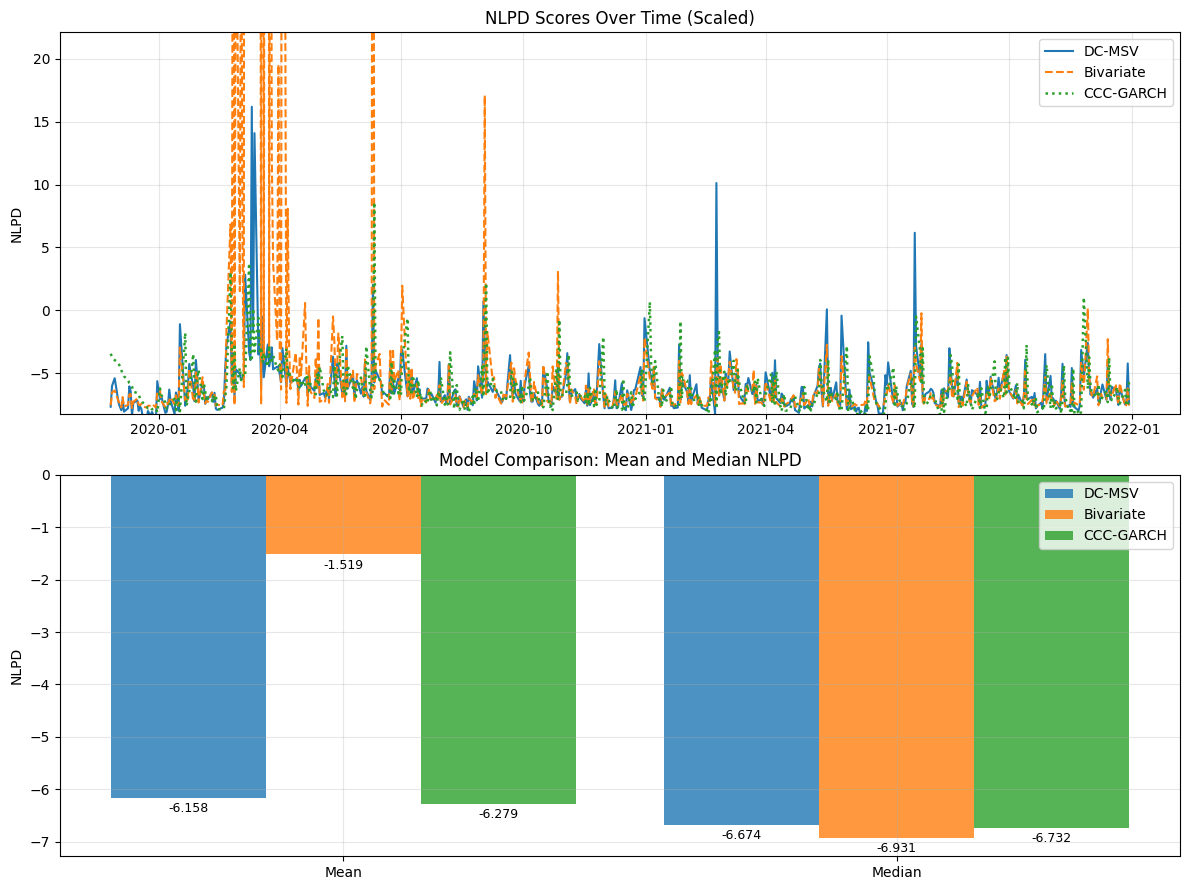

✅ NLPD comparison completed using particle predictions for DC-MSV & Bivariate and closed-form predictive for CCC-GARCH!


In [23]:
from particles_cdssm.collectors import NLPD
from scipy.stats import gaussian_kde, multivariate_normal
import numpy as np

class NLPD_Diagnostic(NLPD):
    """
    Standard NLPD with diagnostic tracking for spike analysis.
    No capping, no cooking - just honest evaluation with logging.
    """
    def __init__(self, spike_threshold=10.0, **kwargs):
        super().__init__(**kwargs)
        self.spike_threshold = spike_threshold
        self.time_step = -1  # Will be incremented to 0 on first call
        self.spike_info = []  # Store info about spikes
        
    def out_func_Y(self, wgts, Y):
        """Returns honest NLPD with diagnostic tracking."""
        if not self.has_y_true:
            return None
        
        self.time_step += 1
        
        # Standard NLPD calculation
        W = wgts.W if not self.rs_flag else None
        kde = gaussian_kde(Y.T, weights=W)
        log_p = kde.logpdf(self.y_true)
        
        if isinstance(log_p, np.ndarray):
            log_p = float(log_p.item())
            
        nlpd = -1. * log_p
        
        # Track spikes for later analysis (but don't modify the value!)
        if nlpd > self.spike_threshold:
            spike_data = {
                'time_step': self.time_step,
                'nlpd': float(nlpd),
                'observation': self.y_true.copy() if hasattr(self.y_true, 'copy') else self.y_true,
                'particle_mean': np.mean(Y, axis=0),
                'particle_std': np.std(Y, axis=0),
                'particle_min': np.min(Y, axis=0),
                'particle_max': np.max(Y, axis=0),
                'num_particles': len(Y)
            }
            self.spike_info.append(spike_data)
            
        return nlpd  # Return honest value

# === NLPD COMPARISON USING PARTICLE PREDICTIONS ===
print("🔄 NLPD COMPARISON USING PARTICLE PREDICTIONS")
print("=" * 50)

# Initialize models with estimated parameters
params = results['estimates']
dc_msv_model = DC_MSV(
    mu1=params['mu1']['mean'], mu2=params['mu2']['mean'],
    phi11=params['phi11']['mean'], phi22=params['phi22']['mean'],
    sigma_eta1=params['sigma1']['mean'], sigma_eta2=params['sigma2']['mean'],
    psi0=params['mu0']['mean'], psi=params['phi']['mean'],
    sigma_rho=params['sigma_rho']['mean']
)

bivariate_model = BivariateNormal(train_array_decimal)

# Set up particle filters
N = 1000  # Number of particles
np.random.seed(42)  # For reproducibility

print(f"\n1. Running particle filters with {N} particles...")

# DC-MSV particle filter
fk_dc = Bootstrap(ssm=dc_msv_model, data=test_array_decimal)
nlpd_collector_dc = NLPD_Diagnostic(spike_threshold=10.0)
smc_dc = particles.SMC(fk=fk_dc, N=N, collect=[nlpd_collector_dc])
smc_dc.run()
print("   ✅ DC-MSV particle filter completed")

# Bivariate particle filter  
fk_biv = Bootstrap(ssm=bivariate_model, data=test_array_decimal)
nlpd_collector_biv = NLPD()
smc_biv = particles.SMC(fk=fk_biv, N=N, collect=[nlpd_collector_biv])
smc_biv.run()
print("   ✅ Bivariate particle filter completed")

# === CCC-GARCH(1,1): one-step-ahead predictive NLPD (no particles) ===
def ccgarch_nlpd_series(test_y, last_train_y, est):
    """
    Compute per-time NLPD for CCC-GARCH(1,1) using one-step-ahead predictive Gaussians.
    test_y: (T,2) decimal returns; last_train_y: (2,)
    est: results_ccc['estimates'] dict with omega/alpha/beta/rho (and optional vbar1, vbar2).
    """
    omega1 = est['omega1']['mean']; alpha1 = est['alpha1']['mean']; beta1  = est['beta1']['mean']
    omega2 = est['omega2']['mean']; alpha2 = est['alpha2']['mean']; beta2  = est['beta2']['mean']
    rho    = float(np.clip(est['rho']['mean'], -0.999, 0.999))
    vbar1  = est.get('vbar1', {}).get('mean', omega1 / max(1e-12, 1 - alpha1 - beta1))
    vbar2  = est.get('vbar2', {}).get('mean', omega2 / max(1e-12, 1 - alpha2 - beta2))

    T = test_y.shape[0]
    y_lag = np.vstack([last_train_y[None, :], test_y[:-1, :]])  # y_{t-1} aligned with test period

    h1, h2 = vbar1, vbar2
    nlpd = np.empty(T, dtype=float)
    Hs   = np.empty((T, 2, 2), dtype=float)
    eps = 1e-12

    for t in range(T):
        y1m1_sq = y_lag[t, 0] ** 2
        y2m1_sq = y_lag[t, 1] ** 2
        h1 = omega1 + alpha1 * y1m1_sq + beta1 * h1
        h2 = omega2 + alpha2 * y2m1_sq + beta2 * h2

        s1, s2 = np.sqrt(max(h1, eps)), np.sqrt(max(h2, eps))
        cov12  = rho * s1 * s2
        H = np.array([[max(h1, eps), cov12],
                      [cov12,        max(h2, eps)]], dtype=float)
        Hs[t] = H

        nlpd[t] = -multivariate_normal.logpdf(test_y[t], mean=np.zeros(2), cov=H)

    return nlpd, Hs

print("\n1c. Computing CCC-GARCH(1,1) NLPD (no particles)...")
last_train_y = train_array_decimal[-1]
nlpd_garch_array, Hs_garch = ccgarch_nlpd_series(
    test_array_decimal,
    last_train_y,
    results_ccc['estimates']  # from your NumPyro CCC-GARCH estimation
)
print("   ✅ CCC-GARCH NLPD computed")

# Extract NLPD values for particle models
print(f"\n2. Extracting NLPD values from collectors...")

def _extract_nlpd_array(nlpd_raw):
    arr = []
    for val in nlpd_raw:
        if val is not None:
            arr.append(float(val.item()) if isinstance(val, np.ndarray) else float(val))
    return np.asarray(arr, dtype=float)

nlpd_dc_array  = _extract_nlpd_array(smc_dc.summaries.nlpd)
nlpd_biv_array = _extract_nlpd_array(smc_biv.summaries.nlpd)

print(f"   📊 DC-MSV NLPD shape: {nlpd_dc_array.shape}")
print(f"   📊 Bivariate NLPD shape: {nlpd_biv_array.shape}")
print(f"   📊 CCC-GARCH NLPD shape: {nlpd_garch_array.shape}")

# Spike analysis remains for DC-MSV (as in your original)
print(f"\n🔍 SPIKE ANALYSIS FOR DC-MSV MODEL")
spike_threshold = 10.0
spike_indices = np.where(nlpd_dc_array > spike_threshold)[0]

if len(spike_indices) > 0:
    print(f"Found {len(spike_indices)} spikes with NLPD > {spike_threshold}")
    print("-" * 80)
    for idx in spike_indices:
        spike_date = test_df.index[idx]
        spike_value = nlpd_dc_array[idx]
        print(f"\nSpike at {spike_date}:")
        print(f"  NLPD value: {spike_value:.2f}")
        print(f"  Test data at this date: {test_array_decimal[idx]}")
        if idx > 0:
            print(f"  Previous day NLPD: {nlpd_dc_array[idx-1]:.2f}")
        if idx < len(nlpd_dc_array) - 1:
            print(f"  Next day NLPD: {nlpd_dc_array[idx+1]:.2f}")
else:
    print("No spikes found above threshold")

# Deeper analysis of the spike (unchanged)
print(f"\n📊 DETAILED SPIKE ANALYSIS")
print("-" * 80)
for idx in spike_indices:
    print(f"\nAnalyzing spike at index {idx} ({test_df.index[idx]}):")
    window = 5
    start_idx = max(0, idx - window)
    end_idx = min(len(test_array_decimal), idx + window + 1)

    print(f"\n  Returns around the spike:")
    for i in range(start_idx, end_idx):
        marker = " <-- SPIKE" if i == idx else ""
        print(f"    {test_df.index[i]}: {test_array_decimal[i]}{marker}")

    if idx >= 10:
        pre_spike_data = test_array_decimal[idx-10:idx]
        pre_spike_corr = np.corrcoef(pre_spike_data[:, 0], pre_spike_data[:, 1])[0, 1]
        print(f"\n  Correlation (10 days before): {pre_spike_corr:.3f}")
    if idx >= 20:
        pre_spike_vol = np.std(test_array_decimal[idx-20:idx], axis=0)
        print(f"  Volatilities (20 days before): {pre_spike_vol}")
        print(f"  Actual returns at spike: {test_array_decimal[idx]}")
        print(f"  Standardized returns: {test_array_decimal[idx] / pre_spike_vol}")

if len(nlpd_dc_array) == 0 or len(nlpd_biv_array) == 0 or len(nlpd_garch_array) == 0:
    raise ValueError("No valid NLPD values extracted")

# After extracting NLPD values but before computing statistics (unchanged DC-MSV spike info block)
if hasattr(nlpd_collector_dc, 'spike_info') and len(nlpd_collector_dc.spike_info) > 0:
    print(f"\n🔍 SPIKE ANALYSIS FOR DC-MSV MODEL")
    print(f"Found {len(nlpd_collector_dc.spike_info)} spikes with NLPD > 10")
    print("-" * 80)
    for i, spike in enumerate(nlpd_collector_dc.spike_info):
        spike_date = test_df.index[spike['time_step']]
        print(f"\nSpike {i+1} at {spike_date}:")
        print(f"  NLPD value: {spike['nlpd']:.2f}")
        print(f"  Observed values: {spike['observation']}")
        print(f"  Particle mean: {spike['particle_mean']}")
        print(f"  Particle std: {spike['particle_std']}")
        print(f"  Particle range: [{spike['particle_min']}, {spike['particle_max']}]")
        z_scores = (spike['observation'] - spike['particle_mean']) / spike['particle_std']
        print(f"  Z-scores: {z_scores}")

# Compute statistics
print(f"\n3. Computing NLPD statistics...")

def _nlpd_stats(a):
    return {
        'mean': np.mean(a),
        'std': np.std(a),
        'median': np.median(a),
        'min': np.min(a),
        'max': np.max(a),
        'n_obs': len(a)
    }

stats_dc = _nlpd_stats(nlpd_dc_array)
stats_biv = _nlpd_stats(nlpd_biv_array)
stats_garch = _nlpd_stats(nlpd_garch_array)

# === ALIGN SERIES LENGTHS ===
len_dc, len_biv, len_garch, len_dates = len(nlpd_dc_array), len(nlpd_biv_array), len(nlpd_garch_array), len(test_df.index)
min_len = min(len_dc, len_biv, len_garch, len_dates)

if not (len_dc == len_biv == len_garch == len_dates):
    print(f"[Alignment] lengths -> DC={len_dc}, BIV={len_biv}, GARCH={len_garch}, dates={len_dates} -> using min_len={min_len}")

# truncate to common length
nlpd_dc_array    = nlpd_dc_array[:min_len]
nlpd_biv_array   = nlpd_biv_array[:min_len]
nlpd_garch_array = nlpd_garch_array[:min_len]
dates            = test_df.index[:min_len]


print(f"\nDC-MSV Model:")
print(f"  Mean NLPD:    {stats_dc['mean']:.4f}")
print(f"  Median NLPD:  {stats_dc['median']:.4f}")
print(f"  Std NLPD:     {stats_dc['std']:.4f}")
print(f"  Min/Max:      {stats_dc['min']:.2f} / {stats_dc['max']:.2f}")
print(f"  Observations: {stats_dc['n_obs']}")

print(f"\nBivariate Model:")
print(f"  Mean NLPD:    {stats_biv['mean']:.4f}")
print(f"  Median NLPD:  {stats_biv['median']:.4f}")
print(f"  Std NLPD:     {stats_biv['std']:.4f}")
print(f"  Min/Max:      {stats_biv['min']:.2f} / {stats_biv['max']:.2f}")
print(f"  Observations: {stats_biv['n_obs']}")

print(f"\nCCC-GARCH(1,1) Model:")
print(f"  Mean NLPD:    {stats_garch['mean']:.4f}")
print(f"  Median NLPD:  {stats_garch['median']:.4f}")
print(f"  Std NLPD:     {stats_garch['std']:.4f}")
print(f"  Min/Max:      {stats_garch['min']:.2f} / {stats_garch['max']:.2f}")
print(f"  Observations: {stats_garch['n_obs']}")

# Model comparison
print(f"\n📊 MODEL COMPARISON SUMMARY:")
print("-" * 50)
print(f"Mean NLPD:    DC-MSV={stats_dc['mean']:.4f} | Bivariate={stats_biv['mean']:.4f} | CCC-GARCH={stats_garch['mean']:.4f}")
print(f"Median NLPD:  DC-MSV={stats_dc['median']:.4f} | Bivariate={stats_biv['median']:.4f} | CCC-GARCH={stats_garch['median']:.4f}")

means = {'DC-MSV': stats_dc['mean'], 'Bivariate': stats_biv['mean'], 'CCC-GARCH': stats_garch['mean']}
winner = min(means, key=means.get)
print(f"\n🏆 Best (by mean NLPD): {winner}")

# Visualization
print("\n4. Creating compact visualizations (first column only)...")

# Build common x-axis (dates) AFTER alignment step you added earlier
dates = test_df.index[:len(nlpd_dc_array)]

# Compute a robust upper limit (suppress extreme spikes)
all_nlpd = np.concatenate([nlpd_dc_array, nlpd_biv_array, nlpd_garch_array])
y_low  = np.percentile(all_nlpd, 1)    # lower clip (optional)
y_high = np.percentile(all_nlpd, 99)   # upper clip for visibility

fig, axes = plt.subplots(2, 1, figsize=(12, 9))

# (Top) Time series with scaled y-axis
axes[0].plot(dates, nlpd_dc_array,    label='DC-MSV',      linewidth=1.5)
axes[0].plot(dates, nlpd_biv_array,   label='Bivariate',   linestyle='--', linewidth=1.5)
axes[0].plot(dates, nlpd_garch_array, label='CCC-GARCH',  linestyle=':',  linewidth=1.8)
axes[0].set_title('NLPD Scores Over Time (Scaled)')
axes[0].set_ylabel('NLPD')
axes[0].set_ylim(y_low, y_high)   # <-- scaling for clarity
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# (Bottom) Bar chart: Mean & Median
metrics = ['Mean', 'Median']
dc_vals    = [stats_dc['mean'],    stats_dc['median']]
biv_vals   = [stats_biv['mean'],   stats_biv['median']]
garch_vals = [stats_garch['mean'], stats_garch['median']]
x = np.arange(len(metrics)); width = 0.28

axes[1].bar(x - width, dc_vals,    width, label='DC-MSV', alpha=0.8)
axes[1].bar(x,         biv_vals,   width, label='Bivariate', alpha=0.8)
axes[1].bar(x + width, garch_vals, width, label='CCC-GARCH', alpha=0.8)
axes[1].set_xticks(x); axes[1].set_xticklabels(metrics)
axes[1].set_ylabel('NLPD')
axes[1].set_title('Model Comparison: Mean and Median NLPD')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Add value labels on bars
for bars in axes[1].containers:
    axes[1].bar_label(bars, fmt='%.3f', padding=3, fontsize=9)

plt.tight_layout()
plt.show()
print("✅ NLPD comparison completed using particle predictions for DC-MSV & Bivariate and closed-form predictive for CCC-GARCH!")


# Bayes Factor Section

In [26]:
import numpy as np
from scipy.stats import gaussian_kde, beta as beta_dist, multivariate_normal, norm
from scipy.special import gammaln, multigammaln, logsumexp
from particles import SMC
from particles.smc_samplers import Bootstrap

# -----------------------------
# Helper: multivariate NIW evidence (Bivariate Normal / Black–Scholes)
# -----------------------------
def log_marginal_bvn_niw(y, mu0=None, kappa0=1e-4, Psi0=None, nu0=None):
    """
    Marginal likelihood for multivariate Gaussian with NIW prior:
      Sigma ~ Inv-Wishart(Psi0, nu0), mu|Sigma ~ N(mu0, Sigma/kappa0)
    y: (T,2), no requirement to demean (mu is integrated out)
    """
    y = np.asarray(y)
    n, d = y.shape
    assert d == 2, "This function expects d=2."

    if mu0 is None:
        mu0 = np.zeros(d)
    if Psi0 is None:
        # weakly-informative scale using data variance
        S_emp = np.cov(y.T) + 1e-8 * np.eye(d)
        Psi0 = 0.01 * S_emp
    if nu0 is None:
        nu0 = d + 2  # minimally informative, > d-1

    # Sufficient stats
    ybar = y.mean(axis=0)
    S = (y - ybar).T @ (y - ybar)

    # Posterior updates
    kappa_n = kappa0 + n
    nu_n = nu0 + n
    delta = (ybar - mu0).reshape(-1, 1)
    Psi_n = Psi0 + S + (kappa0 * n / kappa_n) * (delta @ delta.T)

    # log evidence
    logZ = (
        - (n * d / 2.0) * np.log(np.pi)
        + 0.5 * (np.log(kappa0) - np.log(kappa_n)) * d
        + (multigammaln(nu_n / 2.0, d) - multigammaln(nu0 / 2.0, d))
        + 0.5 * (nu0 * np.log(np.linalg.det(Psi0)) - nu_n * np.log(np.linalg.det(Psi_n)))
    )
    return float(logZ)

# -----------------------------
# DC-MSV: PF likelihood + Chib
# -----------------------------
def _dcmsv_log_prior(theta, y):
    # Match your NumPyro priors (data-informed for mu1,mu2)
    y_mean = float(np.mean(np.log(np.var(y, axis=0) + 1e-6)))
    mu1, mu2, phi11, phi22, sigma1, sigma2, mu0, phi, sigma_rho = theta
    lp = 0.0
    lp += norm.logpdf(mu1, loc=y_mean, scale=1.0)
    lp += norm.logpdf(mu2, loc=y_mean, scale=1.0)

    from scipy.stats import beta as beta_distn, invgamma
    lp += beta_distn.logpdf(phi11, a=20., b=1.5)
    lp += beta_distn.logpdf(phi22, a=20., b=1.5)
    lp += invgamma.logpdf(sigma1, a=2.5, scale=0.025)
    lp += invgamma.logpdf(sigma2, a=2.5, scale=0.025)

    lp += norm.logpdf(mu0, loc=0.7, scale=3.0)
    lp += beta_distn.logpdf(phi, a=20., b=1.5)
    lp += invgamma.logpdf(sigma_rho, a=2.5, scale=0.025)
    return float(lp)

def _dcmsv_loglik_pf(y, theta, N=4000, R=5, essr=0.5):
    """
    PF likelihood at fixed theta, averaged across R runs (log-mean-exp).
    theta = (mu1,mu2,phi11,phi22,sigma1,sigma2,mu0,phi,sigma_rho)
    """
    mu1, mu2, phi11, phi22, sigma1, sigma2, mu0, phi, sigma_rho = theta
    model = DC_MSV(mu1=mu1, mu2=mu2, phi11=phi11, phi22=phi22,
                   sigma_eta1=sigma1, sigma_eta2=sigma2,
                   psi0=mu0, psi=phi, sigma_rho=sigma_rho)
    logLs = []
    for _ in range(R):
        fk = Bootstrap(ssm=model, data=y)
        pf = SMC(fk=fk, N=N, ESSrmin=essr, resampling='stratified')
        pf.run()
        logLs.append(pf.logLt)
    return float(logsumexp(logLs) - np.log(R))

def log_marginal_dcmsv_chib(y, dc_results, N_pf=4000, R_pf=5):
    """
    Chib for DC-MSV with PF likelihood and KDE posterior ordinate (simple, robust).
    dc_results: your dict from numpyro_estimation_dc_msv(...)
    """
    s = dc_results['samples']
    # Build theta* from posterior means
    keys = ['mu1','mu2','phi11','phi22','sigma1','sigma2','mu0','phi','sigma_rho']
    theta_star = np.array([float(np.mean(np.asarray(s[k]))) for k in keys])

    # 1) PF log-likelihood at theta*
    loglik = _dcmsv_loglik_pf(y, theta_star, N=N_pf, R=R_pf)

    # 2) Prior at theta*
    logprior = _dcmsv_log_prior(theta_star, y)

    # 3) Posterior ordinate via KDE in the original parameter space
    stack = np.vstack([np.asarray(s[k]).reshape(-1) for k in keys])
    kde = gaussian_kde(stack)
    logpost = float(kde.logpdf(theta_star))

    return float(loglik + logprior - logpost)

# -----------------------------
# CCC-GARCH(1,1): Chib with unconstrained KDE
# -----------------------------
def _ccc_garch_loglik(y, u1, v1, u2, v2, vbar1, vbar2, rho_uncon, kappa=0.999):
    """
    Correct Gaussian log-likelihood for CCC-GARCH(1,1) using standardized residuals.
      alpha_i = kappa * u_i
      beta_i  = kappa * (1 - u_i) * v_i
      omega_i = vbar_i * (1 - alpha_i - beta_i)
      rho     = 0.98 * tanh(rho_uncon)
    y: (T,2), decimal returns (NOT %).
    """
    y = np.asarray(y)
    T = y.shape[0]
    eps = 1e-12

    # Params
    alpha1 = kappa * u1
    beta1  = kappa * (1. - u1) * v1
    alpha2 = kappa * u2
    beta2  = kappa * (1. - u2) * v2
    # enforce positivity of omegas numerically
    omega1 = max(eps, vbar1 * max(eps, 1. - alpha1 - beta1))
    omega2 = max(eps, vbar2 * max(eps, 1. - alpha2 - beta2))
    rho = float(np.tanh(rho_uncon) * 0.98)
    rho2 = rho * rho

    # Precompute correlation pieces
    detR = 1.0 - rho2
    invR_factor = 1.0 / detR
    log_const_per_t = -0.5 * (2.0 * np.log(2.0 * np.pi) + np.log(detR))

    # Initialize conditional variances at unconditional levels
    h1 = float(vbar1)
    h2 = float(vbar2)

    ll = 0.0
    for t in range(T):
        # one-step-ahead update using lagged observed returns
        if t == 0:
            ylag0, ylag1 = 0.0, 0.0
        else:
            ylag0, ylag1 = y[t-1, 0], y[t-1, 1]

        h1 = omega1 + alpha1 * (ylag0 * ylag0) + beta1 * h1
        h2 = omega2 + alpha2 * (ylag1 * ylag1) + beta2 * h2

        # standard deviations
        s1 = np.sqrt(max(h1, eps))
        s2 = np.sqrt(max(h2, eps))

        # standardized residuals
        e1 = y[t, 0] / s1
        e2 = y[t, 1] / s2

        # quadratic form e' R^{-1} e = (e1^2 - 2 rho e1 e2 + e2^2)/(1 - rho^2)
        quad = (e1*e1 - 2.0 * rho * e1 * e2 + e2*e2) * invR_factor

        # log-density contribution
        ll += (-np.log(s1) - np.log(s2)) + (log_const_per_t - 0.5 * quad)

    return float(ll)


def _log_prior_ccc(u1, v1, u2, v2, vbar1, vbar2, rho_uncon, y):
    """
    Priors aligned with your NumPyro estimation:
      u*, v* ~ Beta(2,2)
      sqrt(vbar_i) ~ HalfNormal(scale=sqrt(sample var_i))
      rho_uncon ~ Normal(0,1)
    """
    from scipy.stats import beta as Beta, norm as Norm
    s2 = np.var(y, axis=0) + 1e-8
    scale1 = np.sqrt(s2[0]); scale2 = np.sqrt(s2[1])

    # Betas on (0,1)
    if not (0 < u1 < 1 and 0 < v1 < 1 and 0 < u2 < 1 and 0 < v2 < 1):
        return -np.inf
    lp = (
        Beta.logpdf(u1, 2., 2.) + Beta.logpdf(v1, 2., 2.) +
        Beta.logpdf(u2, 2., 2.) + Beta.logpdf(v2, 2., 2.)
    )

    # vbar_i via sqrt(vbar) ~ HalfNormal(scale)
    # If X ~ HalfNormal(σ), V=X^2 => f_V(v) = [1 / (σ sqrt(2π v))] exp(-v/(2σ^2))
    def logpdf_vbar(v, sigma):
        if v <= 0:
            return -np.inf
        return -np.log(sigma) - 0.5*np.log(2*np.pi) - 0.5*np.log(v) - v/(2*sigma**2)
    lp += logpdf_vbar(vbar1, scale1) + logpdf_vbar(vbar2, scale2)

    # rho_uncon ~ N(0,1)
    lp += Norm.logpdf(rho_uncon, 0., 1.)
    return float(lp)

def log_marginal_ccc_garch_chib(y, results_ccc, kappa=0.999):
    """
    Chib-style evidence for CCC-GARCH(1,1) using:
      - exact Gaussian likelihood via recursion
      - prior matching your NumPyro setup
      - posterior ordinate via KDE in the unconstrained space:
            z = (logit(u1), logit(v1), logit(u2), logit(v2),
                 rho_uncon, log(vbar1), log(vbar2))
    """
    s = results_ccc['samples']
    # Pull primary parameters present in your estimation
    u1_s = np.asarray(s['u1']).reshape(-1)
    v1_s = np.asarray(s['v1']).reshape(-1)
    u2_s = np.asarray(s['u2']).reshape(-1)
    v2_s = np.asarray(s['v2']).reshape(-1)
    rho_uncon_s = np.asarray(s['rho_uncon']).reshape(-1)
    vbar1_s = np.asarray(s['vbar1']).reshape(-1)
    vbar2_s = np.asarray(s['vbar2']).reshape(-1)

    # Posterior point (means)
    u1, v1, u2, v2 = float(u1_s.mean()), float(v1_s.mean()), float(u2_s.mean()), float(v2_s.mean())
    rho_uncon = float(rho_uncon_s.mean())
    vbar1, vbar2 = float(vbar1_s.mean()), float(vbar2_s.mean())

    # 1) Likelihood at theta*
    loglik = _ccc_garch_loglik(y, u1, v1, u2, v2, vbar1, vbar2, rho_uncon, kappa=kappa)

    # 2) Prior at theta*
    logprior = _log_prior_ccc(u1, v1, u2, v2, vbar1, vbar2, rho_uncon, y)

    # 3) Posterior ordinate via KDE in unconstrained z-space
    def logit(p): return np.log(p) - np.log(1. - p)
    Z = np.vstack([
        logit(u1_s), logit(v1_s), logit(u2_s), logit(v2_s),
        rho_uncon_s, np.log(vbar1_s), np.log(vbar2_s)
    ])
    kde = gaussian_kde(Z)
    z_star = np.array([logit(u1), logit(v1), logit(u2), logit(v2),
                       rho_uncon, np.log(vbar1), np.log(vbar2)])
    logpost_trans = float(kde.logpdf(z_star))

    # Jacobian adjustment: subtract log |dθ/dz|
    jac = (
        np.log(u1*(1-u1)) + np.log(v1*(1-v1)) +
        np.log(u2*(1-u2)) + np.log(v2*(1-v2)) +
        0.0 +  # rho_uncon identity
        np.log(vbar1) + np.log(vbar2)
    )
    logpost = logpost_trans - jac

    return float(loglik + logprior - logpost)
def _ccc_garch_loglik_cov(y, u1, v1, u2, v2, vbar1, vbar2, rho_uncon, kappa=0.999):
    """Reference implementation via H_t = D_t R D_t; must match _ccc_garch_loglik()."""
    y = np.asarray(y)
    T = y.shape[0]
    eps = 1e-12

    alpha1 = kappa * u1
    beta1  = kappa * (1. - u1) * v1
    alpha2 = kappa * u2
    beta2  = kappa * (1. - u2) * v2
    omega1 = max(eps, vbar1 * max(eps, 1. - alpha1 - beta1))
    omega2 = max(eps, vbar2 * max(eps, 1. - alpha2 - beta2))
    rho = float(np.tanh(rho_uncon) * 0.98)

    h1 = float(vbar1)
    h2 = float(vbar2)

    ll = 0.0
    for t in range(T):
        if t == 0:
            ylag = np.zeros(2)
        else:
            ylag = y[t-1]

        h1 = omega1 + alpha1 * (ylag[0] ** 2) + beta1 * h1
        h2 = omega2 + alpha2 * (ylag[1] ** 2) + beta2 * h2

        s1 = np.sqrt(max(h1, eps))
        s2 = np.sqrt(max(h2, eps))
        cov12 = rho * s1 * s2
        H = np.array([[max(h1, eps), cov12],
                      [cov12,        max(h2, eps)]], dtype=float)

        # direct MVN logpdf with full constants
        ll += multivariate_normal.logpdf(y[t], mean=np.zeros(2), cov=H)
    return float(ll)

# Sanity test at θ* (run once):
# ref1 = _ccc_garch_loglik(y, u1, v1, u2, v2, vbar1, vbar2, rho_uncon)
# ref2 = _ccc_garch_loglik_cov(y, u1, v1, u2, v2, vbar1, vbar2, rho_uncon)
# print("Δ (stdres - cov) =", ref1 - ref2)  # should be ~ 0 (|Δ| < 1e-6)

# -----------------------------
# Three-model comparison wrapper
# -----------------------------
def compute_log_bf_all_bivariate(
    y,
    dc_results,
    results_ccc,
    niw_mu0=None,
    niw_kappa0=1e-4,
    niw_Psi0=None,
    niw_nu0=None,
    N_pf=4000,
    R_pf=5
):
    """
    y: (T,2) returns in decimal units (demeaning not required)
    Returns dict with log marginals and pairwise Bayes factors.
    """
    y = np.asarray(y)
    log_m_dcmsv  = log_marginal_dcmsv_chib(y, dc_results, N_pf=N_pf, R_pf=R_pf)
    log_m_ccc    = log_marginal_ccc_garch_chib(y, results_ccc)
    log_m_bvn    = log_marginal_bvn_niw(y, mu0=niw_mu0, kappa0=niw_kappa0, Psi0=niw_Psi0, nu0=niw_nu0)

    out = {
        "log_marginals": {"DC-MSV": log_m_dcmsv, "CCC-GARCH": log_m_ccc, "BVN": log_m_bvn},
        "log_BF": {
            "DCMSV_vs_CCC":  float(log_m_dcmsv - log_m_ccc),
            "DCMSV_vs_BVN":  float(log_m_dcmsv - log_m_bvn),
            "CCC_vs_BVN":    float(log_m_ccc - log_m_bvn)
        }
    }
    return out

# -----------------------------
# Example call (mirrors your style)
# -----------------------------
y_full = np.vstack([train_array_decimal, test_array_decimal])  # (T,2)
res_bivar = compute_log_bf_all_bivariate(
    y_full,
    dc_results=results,            # from numpyro_estimation_dc_msv(...)
    results_ccc=results_ccc,       # from numpyro_estimation_ccc_garch11(...)
    N_pf=4000, R_pf=5
)
print(res_bivar)
print(f"Log BF (DC-MSV over CCC): {res_bivar['log_BF']['DCMSV_vs_CCC']:.3f}")
print(f"Log BF (DC-MSV over BVN): {res_bivar['log_BF']['DCMSV_vs_BVN']:.3f}")
print(f"Log BF (CCC over BVN):    {res_bivar['log_BF']['CCC_vs_BVN']:.3f}")


{'log_marginals': {'DC-MSV': 11795.347102342072, 'CCC-GARCH': 7145.245431073306, 'BVN': 11299.747689861331}, 'log_BF': {'DCMSV_vs_CCC': 4650.101671268766, 'DCMSV_vs_BVN': 495.5994124807403, 'CCC_vs_BVN': -4154.502258788026}}
Log BF (DC-MSV over CCC): 4650.102
Log BF (DC-MSV over BVN): 495.599
Log BF (CCC over BVN):    -4154.502


In [30]:
# ============================================================
# 2D BAYES FACTOR COMPARISON: DC-MSV vs CCC-GARCH(1,1) vs BVN
# (with robust likelihoods, priors, transforms, and checks)
# ============================================================

import numpy as np
from numpy.linalg import slogdet, inv
from scipy.special import gammaln
from scipy.stats import gaussian_kde
from dataclasses import dataclass

# If you use particles:
# (Use module-level imports that actually exist in `particles`.)
from particles import state_space_models as ssm
from particles import distributions as dists
from particles import SMC 

# -----------------------------
# UTILITIES / GUARDS
# -----------------------------
def _assert_finite(name, arr):
    if not np.all(np.isfinite(arr)):
        bad = np.where(~np.isfinite(arr))[0][:5]
        raise ValueError(f"{name} has non-finite values at indices {bad} (showing up to 5).")

def _align_2d(y):
    """Ensure y is a 2D numpy array (T,2), finite, no NaNs."""
    y = np.asarray(y)
    if y.ndim == 1:
        if y.size % 2 != 0:
            raise ValueError("Provided 1D y length is not divisible by 2.")
        y = y.reshape(-1, 2)
    if y.shape[1] != 2:
        raise ValueError(f"y must have 2 columns, got {y.shape}.")
    _assert_finite("y", y)
    return y

def _per_obs(ll, T):
    return float(ll) / float(T)

# -----------------------------
# BVN (Bivariate Normal) — NIW Closed-form Marginal
# -----------------------------
@dataclass
class NIWPrior:
    m0: np.ndarray   # (2,) prior mean
    kappa0: float    # scalar > 0
    S0: np.ndarray   # (2,2) scale (sum-of-squares) matrix
    nu0: float       # dof > 1

def _log_multigamma_d2(a):
    # Γ_2(a) = π^{1/2} Γ(a) Γ(a - 1/2)
    from math import log, pi
    from scipy.special import gammaln as gln
    return 0.5 * np.log(pi) + gln(a) + gln(a - 0.5)

def log_marginal_bvn_niw(y, prior: NIWPrior):
    """
    Conjugate NIW marginal for y_t ~ N2(mu, Sigma), t=1..T.
    """
    y = _align_2d(y)
    T = y.shape[0]
    if T == 0:
        return 0.0

    m0 = np.asarray(prior.m0).reshape(2,)
    k0 = float(prior.kappa0)
    S0 = np.asarray(prior.S0).reshape(2, 2)
    nu0 = float(prior.nu0)

    # Sample stats
    ybar = np.mean(y, axis=0)
    S = (y - ybar).T @ (y - ybar)

    kT  = k0 + T
    nuT = nu0 + T
    m_diff = (ybar - m0).reshape(2,1)
    ST = S0 + S + (k0*T / kT) * (m_diff @ m_diff.T)

    # log |S0| and |ST|
    sign0, logdetS0 = slogdet(S0)
    signT, logdetST = slogdet(ST)
    if sign0 <= 0 or signT <= 0:
        raise ValueError("Prior S0 or posterior ST not PD (slogdet sign <= 0).")

    d = 2
    # log marginal likelihood (exact NIW form; uses multivariate gamma)
    log_m = (
        - (T * d / 2) * np.log(2*np.pi)
        + (d/2) * (np.log(k0) - np.log(kT))
        + ( (nu0/2) * logdetS0 - (nuT/2) * logdetST )
        + (_log_multigamma_d2(nuT/2) - _log_multigamma_d2(nu0/2))
    )
    return float(log_m)

# -----------------------------
# CCC-GARCH(1,1) 2D — Likelihood + Chib-style Marginal
# -----------------------------
def _ccc_garch_loglik_zero_mean(y, params):
    """
    y_t in R^2, zero-mean, D_t = diag(h1_t**0.5, h2_t**0.5), Sigma_t = D_t * R * D_t
    Recurrence: h_i,t = omega_i + alpha_i * y_{i,t-1}^2 + beta_i * h_{i,t-1}
    """
    y = _align_2d(y)
    T = y.shape[0]

    omega1, alpha1, beta1 = params['omega1'], params['alpha1'], params['beta1']
    omega2, alpha2, beta2 = params['omega2'], params['alpha2'], params['beta2']
    rho = params['rho']

    # Guards
    for nm, v in [('omega1',omega1),('alpha1',alpha1),('beta1',beta1),
                  ('omega2',omega2),('alpha2',alpha2),('beta2',beta2),('rho',rho)]:
        if not np.isfinite(v):
            return -np.inf

    eps = 1e-12
    if not (-0.999 < rho < 0.999):
        return -np.inf

    # Initialize variances at unconditional if stationary; else sample var
    def _h0(series, w, a, b):
        if (a + b) < 1.0 and w > 0:
            return w / max(1.0 - a - b, eps)
        v = np.var(series)
        return v if v > eps else 1.0

    h1_prev = _h0(y[:,0], omega1, alpha1, beta1)
    h2_prev = _h0(y[:,1], omega2, alpha2, beta2)

    # Constant-correlation covariance core
    R = np.array([[1.0, rho],[rho, 1.0]])
    signR, logdetR = slogdet(R)
    if signR <= 0:
        return -np.inf
    invR = inv(R)

    ll = 0.0
    two_pi = np.log(2*np.pi)
    for t in range(T):
        yprev = y[t-1] if t > 0 else np.zeros(2)

        h1_t = omega1 + alpha1 * (yprev[0]**2) + beta1 * h1_prev
        h2_t = omega2 + alpha2 * (yprev[1]**2) + beta2 * h2_prev
        if h1_t <= eps or h2_t <= eps:
            return -np.inf

        # Sigma_t = D * R * D
        sqrt_h1, sqrt_h2 = np.sqrt(h1_t), np.sqrt(h2_t)
        det_Sigma_t = h1_t * h2_t * (1 - rho**2)
        if det_Sigma_t <= eps:
            return -np.inf

        # z = D^{-1} y_t
        z1, z2 = y[t,0] / sqrt_h1, y[t,1] / sqrt_h2
        z = np.array([z1, z2])
        quad = z @ invR @ z

        ll += -0.5 * (two_pi*2 + np.log(det_Sigma_t) + quad)

        # advance
        h1_prev, h2_prev = h1_t, h2_t

    return float(ll)

def _log_prior_ccc_numpyro(params):
    """
    Pragmatic prior; keep as-is unless you want to match the exact stick-breaking prior.
    """
    from scipy.stats import beta as beta_dist

    # Bounds for omega (tune if your data scale differs)
    low1, high1 = 1e-8, 1e-2
    low2, high2 = 1e-8, 1e-2

    w1, a1, b1 = params['omega1'], params['alpha1'], params['beta1']
    w2, a2, b2 = params['omega2'], params['alpha2'], params['beta2']
    rho       = params['rho']

    if not (low1 < w1 < high1 and low2 < w2 < high2):
        return -np.inf
    lp = -np.log(high1 - low1) - np.log(high2 - low2)

    def beta_logpdf(x, aa, bb):
        if not (0.0 < x < 1.0): return -np.inf
        return beta_dist.logpdf(x, aa, bb)

    lp += beta_logpdf(a1, 2, 5) + beta_logpdf(b1, 5, 2)
    lp += beta_logpdf(a2, 2, 5) + beta_logpdf(b2, 5, 2)

    if not (-0.99 < rho < 0.99):
        return -np.inf
    lp += -np.log(1.98)  # Uniform(-0.99,0.99)

    # Soft stationarity penalties
    for a,b in [(a1,b1),(a2,b2)]:
        if (a + b) >= 0.999:
            lp += -100.0 * (a + b - 0.999)**2

    return float(lp)

def _kde_logpost_ccc(samples):
    """
    KDE posterior ordinate in transformed space:
      u_i = log(omega_i), v_i = logit(alpha_i), w_i = logit(beta_i), r = atanh(rho)
    Jacobian correction from (u,v,w,r) -> (omega,alpha,beta,rho)
    """
    def logit(p): return np.log(p) - np.log(1.0 - p)
    def atanh_r(r): return 0.5*np.log((1+r)/(1-r))

    w1 = np.log(samples['omega1'])
    w2 = np.log(samples['omega2'])
    v1 = logit(samples['alpha1'])
    v2 = logit(samples['alpha2'])
    t1 = logit(samples['beta1'])
    t2 = logit(samples['beta2'])
    r  = atanh_r(samples['rho'])

    Z = np.vstack([w1, w2, v1, v2, t1, t2, r])
    kde = gaussian_kde(Z)

    # Star point = posterior mean in original space, then transformed
    theta_star = {
        k: float(np.mean(v))
        for k, v in samples.items()
    }
    eps = 1e-12
    w1s = np.log(max(theta_star['omega1'], eps))
    w2s = np.log(max(theta_star['omega2'], eps))
    # clip away from {0,1}
    def clip01(x): return float(np.clip(x, 1e-6, 1. - 1e-6))
    v1s = logit(clip01(theta_star['alpha1']))
    v2s = logit(clip01(theta_star['alpha2']))
    t1s = logit(clip01(theta_star['beta1']))
    t2s = logit(clip01(theta_star['beta2']))
    rs  = atanh_r(np.clip(theta_star['rho'], -0.98, 0.98))

    log_post_trans = float(kde.logpdf([w1s, w2s, v1s, v2s, t1s, t2s, rs]))

    # Jacobian |dz/dtheta| terms (log):
    J = (
        np.log(theta_star['omega1']) + np.log(theta_star['omega2'])
        + np.log(theta_star['alpha1']*(1-theta_star['alpha1']))
        + np.log(theta_star['alpha2']*(1-theta_star['alpha2']))
        + np.log(theta_star['beta1'] *(1-theta_star['beta1']))
        + np.log(theta_star['beta2'] *(1-theta_star['beta2']))
        + np.log(1.0 - theta_star['rho']**2)
    )
    log_post = log_post_trans - J
    return theta_star, log_post

def log_marginal_ccc_garch_chib(y, garch_results):
    """
    Chib-style: log m = log p(y|theta*) + log p(theta*) - log p(theta*|y)
    where theta* = posterior mean (original space)
    """
    y = _align_2d(y)

    # Grab posterior draws (NumPy arrays)
    if 'samples' in garch_results:
        s = garch_results['samples']
    else:
        s = garch_results['mcmc'].get_samples()

    samples = {
        'omega1': np.asarray(s['omega1']).reshape(-1),
        'alpha1': np.asarray(s['alpha1']).reshape(-1),
        'beta1' : np.asarray(s['beta1']).reshape(-1),
        'omega2': np.asarray(s['omega2']).reshape(-1),
        'alpha2': np.asarray(s['alpha2']).reshape(-1),
        'beta2' : np.asarray(s['beta2']).reshape(-1),
        'rho'   : np.asarray(s['rho']).reshape(-1),
    }

    theta_star, log_post = _kde_logpost_ccc(samples)

    log_lik = _ccc_garch_loglik_zero_mean(y, theta_star)
    log_prior = _log_prior_ccc_numpyro(theta_star)

    return float(log_lik + log_prior - log_post)

# -----------------------------
# DC-MSV — PF Likelihood + Chib wrapper (working hooks)
# -----------------------------
def estimate_loglik_dcmsv_pf(y, theta, N=10_000):
    y = _align_2d(y)

    model = DC_MSV(
        mu1=theta['mu1'], mu2=theta['mu2'],
        phi11=theta['phi11'], phi22=theta['phi22'],
        sigma_eta1=theta['sigma1'], sigma_eta2=theta['sigma2'],
        psi0=theta['mu0'], psi=theta['phi'], sigma_rho=theta['sigma_rho']
    )

    # Bootstrap PF from `particles`
    fk = ssm.Bootstrap(ssm=model, data=y)
    pf = SMC(fk=fk, N=int(N), ESSrmin=0.5, resampling='stratified')  # <- use SMC directly
    pf.run()
    return float(pf.logLt)


def log_prior_dcmsv(theta, y_for_mu=None):
    """
    Mirror your DC-MSV NumPyro priors exactly:
      mu1, mu2 ~ Normal(y_mean, 1.0), where y_mean = mean(log(var(y) + 1e-6))
      phi11, phi22, phi ~ Beta(20, 1.5)
      sigma1, sigma2, sigma_rho ~ InverseGamma(2.5, 0.025)
      mu0 ~ Normal(0.7, 3.0)
    """
    from scipy.stats import norm, invgamma, beta as beta_dist

    # Data-informed mean for mu1, mu2:
    if y_for_mu is None:
        raise ValueError("Provide y_for_mu to compute the data-informed prior mean for mu1/mu2.")
    y_for_mu = _align_2d(y_for_mu)
    y_mean = float(np.mean(np.log(np.var(y_for_mu, axis=0) + 1e-6)))

    mu1, mu2 = theta['mu1'], theta['mu2']
    mu0      = theta['mu0']
    phi11, phi22, phi = theta['phi11'], theta['phi22'], theta['phi']
    sigma1, sigma2, sigma_rho = theta['sigma1'], theta['sigma2'], theta['sigma_rho']

    # Support checks
    if not (0.0 < phi11 < 1.0 and 0.0 < phi22 < 1.0 and 0.0 < phi < 1.0):
        return -np.inf
    if not (sigma1 > 0.0 and sigma2 > 0.0 and sigma_rho > 0.0):
        return -np.inf

    lp  = norm.logpdf(mu1, loc=y_mean, scale=1.0)
    lp += norm.logpdf(mu2, loc=y_mean, scale=1.0)
    lp += norm.logpdf(mu0, loc=0.7,  scale=3.0)

    lp += beta_dist.logpdf(phi11, 20.0, 1.5)
    lp += beta_dist.logpdf(phi22, 20.0, 1.5)
    lp += beta_dist.logpdf(phi,   20.0, 1.5)

    # Inverse-Gamma: SciPy parameterization uses `scale=beta`
    lp += invgamma.logpdf(sigma1, a=2.5, scale=0.025)
    lp += invgamma.logpdf(sigma2, a=2.5, scale=0.025)
    lp += invgamma.logpdf(sigma_rho, a=2.5, scale=0.025)

    return float(lp)

def _kde_logpost_dcmsv(samples, star=None):
    """
    KDE posterior ordinate with appropriate transforms:
      - log for positive scales: sigma1, sigma2, sigma_rho
      - logit for (0,1): phi11, phi22, phi
      - identity for: mu1, mu2, mu0
    Includes Jacobian corrections (as in the CCC section).
    """
    # Restrict to parameter vector of interest
    keys = ['mu1','mu2','phi11','phi22','sigma1','sigma2','mu0','phi','sigma_rho']
    for k in keys:
        if k not in samples:
            raise KeyError(f"Missing '{k}' in DC-MSV samples.")

    # Helpers
    def logit(p): return np.log(p) - np.log(1.0 - p)
    def safe_clip01(x): return np.clip(x, 1e-6, 1. - 1e-6)
    def safe_pos(x): return np.maximum(x, 1e-12)

    # Build transformed matrix Z (d x n)
    z_stack = [
        np.asarray(samples['mu1']).reshape(-1),
        np.asarray(samples['mu2']).reshape(-1),
        logit(safe_clip01(np.asarray(samples['phi11']).reshape(-1))),
        logit(safe_clip01(np.asarray(samples['phi22']).reshape(-1))),
        np.log(safe_pos(np.asarray(samples['sigma1']).reshape(-1))),
        np.log(safe_pos(np.asarray(samples['sigma2']).reshape(-1))),
        np.asarray(samples['mu0']).reshape(-1),
        logit(safe_clip01(np.asarray(samples['phi']).reshape(-1))),
        np.log(safe_pos(np.asarray(samples['sigma_rho']).reshape(-1))),
    ]
    Z = np.vstack(z_stack)
    kde = gaussian_kde(Z)

    # Star = posterior mean in ORIGINAL space, then transform
    if star is None:
        star = {k: float(np.mean(np.asarray(samples[k]).reshape(-1))) for k in keys}

    zstar = np.array([
        star['mu1'],
        star['mu2'],
        logit(safe_clip01(star['phi11'])),
        logit(safe_clip01(star['phi22'])),
        np.log(safe_pos(star['sigma1'])),
        np.log(safe_pos(star['sigma2'])),
        star['mu0'],
        logit(safe_clip01(star['phi'])),
        np.log(safe_pos(star['sigma_rho'])),
    ])
    log_post_trans = float(kde.logpdf(zstar))

    # Jacobian log|dz/dtheta|:
    J = (
        # mu1, mu2, mu0: identity -> 0
        np.log(star['phi11'] * (1. - star['phi11']))   # for logit(phi11): subtract this later
        + np.log(star['phi22'] * (1. - star['phi22'])) # for logit(phi22)
        + np.log(star['phi']   * (1. - star['phi']))   # for logit(phi)
        + np.log(star['sigma1'])                       # for log(sigma1)
        + np.log(star['sigma2'])                       # for log(sigma2)
        + np.log(star['sigma_rho'])                    # for log(sigma_rho)
    )
    # p(theta|y) = p(z|y) * |dz/dtheta|  => log p(theta|y) = log p(z|y) - J_terms(defined as +logs above)
    log_post = log_post_trans - J
    return star, log_post

def log_marginal_dcmsv_pf_chib(y, dc_results, N_pf=10_000):
    """
    PF estimate of log p(y|theta*) + log prior - log posterior ordinate (KDE).
    Uses only true parameter draws (filters out latent states etc.).
    """
    y = _align_2d(y)

    # Extract posterior draws
    if isinstance(dc_results, dict) and 'samples' in dc_results:
        s = dc_results['samples']
    else:
        s = dc_results['mcmc'].get_samples()

    # Keep ONLY parameter draws (ignore states, tildes, etc.)
    needed = ['mu1','mu2','phi11','phi22','sigma1','sigma2','mu0','phi','sigma_rho']
    samples = {k: np.asarray(s[k]).reshape(-1) for k in needed}

    theta_star, log_post = _kde_logpost_dcmsv(samples)

    # PF log-likelihood at theta*
    log_lik = estimate_loglik_dcmsv_pf(y, theta_star, N=N_pf)

    # Prior at theta* (uses data-informed y_mean)
    log_prior = log_prior_dcmsv(theta_star, y_for_mu=y)

    return float(log_lik + log_prior - log_post)

# -----------------------------
# MASTER WRAPPER
# -----------------------------
def compute_log_bf_2d_full_bayes(
    y_all,
    dc_results,
    garch_results,
    bvn_prior=None,
    N_pf=10_000,
    label_map=("DC-MSV","CCC-GARCH","BVN")
):
    """
    y_all: np.ndarray with BOTH TRAIN + TEST (already in decimals) shape (T,2)
    dc_results: your NumPyro DC-MSV fit (dict with 'samples' or an MCMC object)
    garch_results: your NumPyro CCC-GARCH(1,1) fit (dict with 'samples' or MCMC)
    bvn_prior: NIWPrior (if None, a weakly-informative default is used)
    """
    y = _align_2d(y_all)
    T = y.shape[0]

    # BVN prior default (weakly inf.): m0=0, kappa0=.01, S0 = .01*I + sample cov, nu0 = 4
    if bvn_prior is None:
        m0 = np.zeros(2)
        kappa0 = 0.01
        S_emp = np.cov(y.T)
        S0 = 0.01*np.eye(2) + S_emp
        nu0 = 4.0  # > 3 to ensure finite moments
        bvn_prior = NIWPrior(m0=m0, kappa0=kappa0, S0=S0, nu0=nu0)

    # 1) BVN closed-form
    logm_bvn = log_marginal_bvn_niw(y, bvn_prior)

    # 2) CCC-GARCH Chib
    logm_ccc = log_marginal_ccc_garch_chib(y, garch_results)

    # 3) DC-MSV PF+Chib
    logm_dcmsv = log_marginal_dcmsv_pf_chib(y, dc_results, N_pf=N_pf)

    # Assemble
    names = list(label_map)
    out = {
        "log_marginals": {names[0]: logm_dcmsv, names[1]: logm_ccc, names[2]: logm_bvn},
        "log_BF": {
            f"{names[0]}_vs_{names[1]}": float(logm_dcmsv - logm_ccc),
            f"{names[0]}_vs_{names[2]}": float(logm_dcmsv - logm_bvn),
            f"{names[1]}_vs_{names[2]}": float(logm_ccc   - logm_bvn),
        },
        "per_obs_loglik": {
            names[0]: _per_obs(logm_dcmsv, T),
            names[1]: _per_obs(logm_ccc,   T),
            names[2]: _per_obs(logm_bvn,   T),
        }
    }
    return out

# -----------------------------
# EXAMPLE CALL (works with your earlier pipeline)
# -----------------------------
# # 1) Data in DECIMALS (stack train+test, or just use full array)
y_all = np.vstack([train_array_decimal, test_array_decimal])
#
# # 2) Model fits from earlier:
# #    - DC-MSV NumPyro results dict: `results`
# #    - CCC-GARCH(1,1) NumPyro results dict: `results_ccc`
#
# # 3) Run Bayes factor comparison
res = compute_log_bf_2d_full_bayes(y_all, dc_results=results, garch_results=results_ccc, N_pf=5000)
print(res)
bnames = list(res["log_marginals"].keys())
print(f"Log BF ({bnames[0]} over {bnames[1]}): {res['log_BF'][f'{bnames[0]}_vs_{bnames[1]}']:.3f}")
print(f"Per-obs log m ({bnames[2]}, {bnames[1]}, {bnames[0]}): "
      f"{res['per_obs_loglik'][bnames[2]]:.6f}, {res['per_obs_loglik'][bnames[1]]:.6f}, {res['per_obs_loglik'][bnames[0]]:.6f}")


{'log_marginals': {'DC-MSV': 11793.263895051554, 'CCC-GARCH': 11919.998590063593, 'BVN': 9954.47987496652}, 'log_BF': {'DC-MSV_vs_CCC-GARCH': -126.73469501203908, 'DC-MSV_vs_BVN': 1838.7840200850333, 'CCC-GARCH_vs_BVN': 1965.5187150970723}, 'per_obs_loglik': {'DC-MSV': 6.693112312742085, 'CCC-GARCH': 6.76503892739137, 'BVN': 5.6495345487891715}}
Log BF (DC-MSV over CCC-GARCH): -126.735
Per-obs log m (BVN, CCC-GARCH, DC-MSV): 5.649535, 6.765039, 6.693112
